In [2]:
import numpy as np
import os
# %matplotlib notebook
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

# Variable Velocity

In [5]:
# Original dataset angles; 1100 videos of 60 frames / angles each
all_angles = np.load("./circular_motion/all_angles.npy")
sin_angles = np.sin(all_angles)

# 110 test datapoints; 110 videos of 57 frames each = 6270 x 2 variables, 6270 x 1 ids
ids = np.load("/home/dmi/neural-state-variables/scripts/logs_circular_motion_refine-64_1/variables/ids.npy")
raw_vars = np.load("/home/dmi/neural-state-variables/scripts/logs_circular_motion_refine-64_1/variables/refine_latent.npy")

angles = all_angles[524]
angles = angles[3:] # Ignore first 3 frames 
var1 = raw_vars[:57, 0]
var2 = raw_vars[:57, 1]
ids1 = ids[:57]
print(var1.shape)
print(angles.shape)


(57,)
(57,)


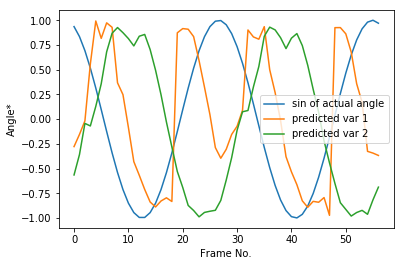

In [8]:
plt.plot(np.sin(angles), label='sin of actual angle')
plt.plot(var1, label='predicted var 1')
plt.plot(var2, label='predicted var 2')
# plt.plot(np.sin(var1))
# plt.plot(np.sin(var2))
var3 = var1 + var2
var4 = np.sin(var3)
# plt.plot(var3, label='var1 + var2')
# plt.plot(var4, label='sin (var1 + var2)')
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_vars = []
train_angles = []
train_ids = []

curr_id = -1
for i in range(0, len(ids), 57):
    set_id = int(ids[i].split("_")[0])
    a = all_angles[set_id][3:]
    v = raw_vars[i:i+57]
    
    train_ids.append(set_id)
    train_angles.append(a)
    train_vars.append(v)

In [11]:
X = np.array(train_vars)
y = np.array(train_angles)
train_ids = np.array(train_ids)
print(train_ids.shape)
print(np.array(X).shape)
print(np.array(y).shape)
print(X[0].shape)
print(X[0][:,0].shape)

(110,)
(110, 57, 2)
(110, 57)
(57, 2)
(57,)


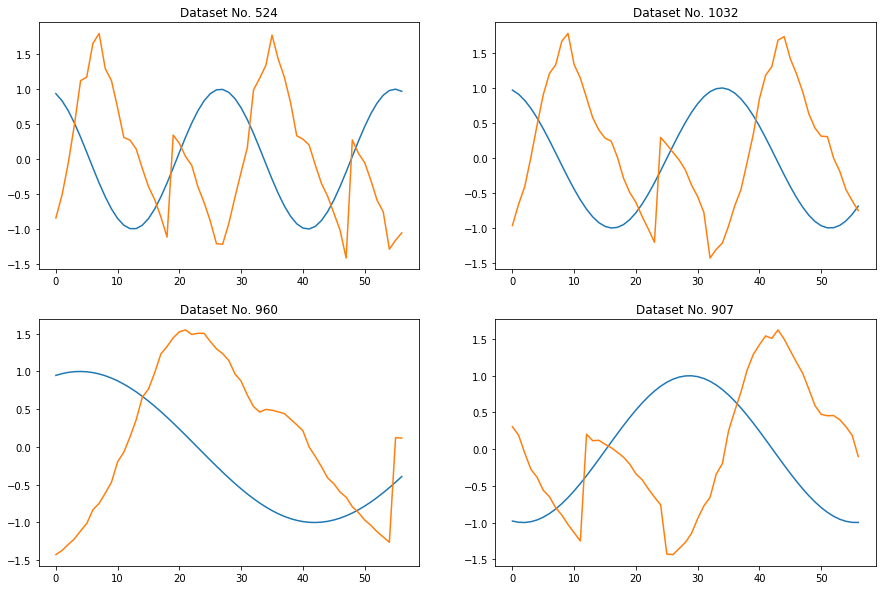

In [12]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 10))
  
axis[0, 0].plot(np.sin(y[0]), label="sin()")
# axis[0, 0].plot(X[0][:,0], label="var1")
# axis[0, 0].plot(X[0][:,1], label="var2")
axis[0, 0].plot(X[0][:,0] + X[0][:,1], label="var1 + var2")
axis[0, 0].set_title(f"Dataset No. {train_ids[0]}")

axis[0, 1].plot(np.sin(y[1]), label="sin()")
# axis[0, 1].plot(X[1][:,0], label="var1")
# axis[0, 1].plot(X[1][:,1], label="var2")
axis[0, 1].plot(X[1][:,0] + X[1][:,1], label="var1 + var2")
axis[0, 1].set_title(f"Dataset No. {train_ids[1]}")
  
axis[1, 0].plot(np.sin(y[2]), label="sin()")
# axis[1, 0].plot(X[2][:,0], label="var1")
# axis[1, 0].plot(X[2][:,1], label="var2")
axis[1, 0].plot(X[2][:,0] + X[2][:,1], label="var1 + var2")
axis[1, 0].set_title(f"Dataset No. {train_ids[2]}")
  
axis[1, 1].plot(np.sin(y[3]), label="sin()")
# axis[1, 1].plot(X[3][:,0], label="var1")
# axis[1, 1].plot(X[3][:,1], label="var2")
axis[1, 1].plot(X[3][:,0] + X[3][:,1], label="var1 + var2")
axis[1, 1].set_title(f"Dataset No. {train_ids[3]}")
  
# Combine all the operations and display
plt.show()

In [14]:
# Split into 108 training videos and 2 test videos
y = np.sin(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()
print(X_train[0].shape)
print(y_train[0].shape)
# print(X_train[0])

(108, 57, 2)
(108, 57)
(2, 57, 2)
(2, 57)
torch.Size([108, 57, 2])
torch.Size([108, 57])
torch.Size([2, 57, 2])
torch.Size([2, 57])

torch.Size([57, 2])
torch.Size([57])


torch.Size([57])
torch.Size([57, 2])
torch.Size([57])


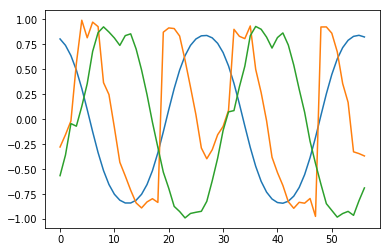

In [16]:
# x = torch.linspace(-math.pi, math.pi, 2000)
x = torch.linspace(-math.pi, math.pi, 57)
# x = torch.linspace(0, 2*math.pi, 60)
# print(x)
# y = torch.sin(x)
# print(y)

# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
# xx = x.unsqueeze(-1).pow(p)
xx = X_train[0]
print(y.shape)
print(xx.shape)
# print(xx)
plt.plot(y_train[0])
print(y_train[0].shape)
y = y_train[0]
plt.plot(xx)

In [17]:
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 30),
    nn.Tanh(),
    torch.nn.Linear(30, 60),
    nn.Tanh(),
    torch.nn.Linear(60, 30),
    nn.Tanh(),
    torch.nn.Linear(30, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

avg_loss = 0
for e in range(1000):
    for i in range(len(X_train)):
        # Get inputs
        y = y_train[i]
        x = X_train[i]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
        if i % 100 == 99:
            print(f"iter {i}; loss {loss.item()}, avg loss {avg_loss}")
            avg_loss = 0

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

iter 99; loss 5.666617393493652, avg loss 468.7371065020561
iter 99; loss 4.062192916870117, avg loss 217.25991356372833
iter 99; loss 3.474219560623169, avg loss 174.60768866539001
iter 99; loss 3.2460439205169678, avg loss 155.85643821954727
iter 99; loss 3.0910425186157227, avg loss 146.2616559267044
iter 99; loss 2.929180145263672, avg loss 139.29806643724442
iter 99; loss 2.7558701038360596, avg loss 132.98731490969658
iter 99; loss 2.564514398574829, avg loss 126.58327832818031
iter 99; loss 2.3542182445526123, avg loss 119.84009197354317
iter 99; loss 2.1323697566986084, avg loss 112.21948182582855
iter 99; loss 1.920567274093628, avg loss 103.3678514957428
iter 99; loss 1.7263847589492798, avg loss 94.47842010855675
iter 99; loss 1.5504049062728882, avg loss 86.21137015521526
iter 99; loss 1.3968045711517334, avg loss 78.56234101951122
iter 99; loss 1.2659159898757935, avg loss 71.81108970940113
iter 99; loss 1.1517720222473145, avg loss 66.26164443045855
iter 99; loss 1.047759

iter 99; loss 0.07375769317150116, avg loss 8.585115922614932
iter 99; loss 0.07365678250789642, avg loss 8.552496774122119
iter 99; loss 0.07355710119009018, avg loss 8.521185707300901
iter 99; loss 0.0734589546918869, avg loss 8.491004141047597
iter 99; loss 0.07336410880088806, avg loss 8.461785413324833
iter 99; loss 0.07327485829591751, avg loss 8.433399204164743
iter 99; loss 0.07319321483373642, avg loss 8.405740635469556
iter 99; loss 0.07312082499265671, avg loss 8.378736533224583
iter 99; loss 0.07305826246738434, avg loss 8.352323848754168
iter 99; loss 0.07300620526075363, avg loss 8.326459888368845
iter 99; loss 0.0729643851518631, avg loss 8.301114017143846
iter 99; loss 0.07293257862329483, avg loss 8.27626534551382
iter 99; loss 0.07290976494550705, avg loss 8.25189371779561
iter 99; loss 0.07289525866508484, avg loss 8.227980138733983
iter 99; loss 0.07288752496242523, avg loss 8.20452175103128
iter 99; loss 0.0728854387998581, avg loss 8.181507132947445
iter 99; loss 

iter 99; loss 0.06394090503454208, avg loss 6.875224882736802
iter 99; loss 0.06387495994567871, avg loss 6.870695684105158
iter 99; loss 0.06381039321422577, avg loss 6.866168648004532
iter 99; loss 0.06374756246805191, avg loss 6.861649729311466
iter 99; loss 0.06368599832057953, avg loss 6.857145644724369
iter 99; loss 0.06362581253051758, avg loss 6.852682268247008
iter 99; loss 0.0635666474699974, avg loss 6.848262334242463
iter 99; loss 0.06350814551115036, avg loss 6.84389415755868
iter 99; loss 0.06345022469758987, avg loss 6.839573707431555
iter 99; loss 0.06339278072118759, avg loss 6.835305441170931
iter 99; loss 0.06333566457033157, avg loss 6.831083621829748
iter 99; loss 0.06327908486127853, avg loss 6.826908923685551
iter 99; loss 0.06322256475687027, avg loss 6.8227768037468195
iter 99; loss 0.06316609680652618, avg loss 6.818689998239279
iter 99; loss 0.06310999393463135, avg loss 6.814642379060388
iter 99; loss 0.0630539283156395, avg loss 6.810633143410087
iter 99; l

iter 99; loss 0.05694963037967682, avg loss 6.443699171766639
iter 99; loss 0.056927066296339035, avg loss 6.441147839650512
iter 99; loss 0.0569070503115654, avg loss 6.43853672221303
iter 99; loss 0.05688474327325821, avg loss 6.435868484899402
iter 99; loss 0.05685575678944588, avg loss 6.433217646554112
iter 99; loss 0.056815005838871, avg loss 6.430641107261181
iter 99; loss 0.05677082762122154, avg loss 6.428096579387784
iter 99; loss 0.056732822209596634, avg loss 6.425688276067376
iter 99; loss 0.05670298635959625, avg loss 6.423432422801852
iter 99; loss 0.056685276329517365, avg loss 6.421182340011001
iter 99; loss 0.05667876824736595, avg loss 6.418827459216118
iter 99; loss 0.056676819920539856, avg loss 6.416353018954396
iter 99; loss 0.056671496480703354, avg loss 6.413795687258244
iter 99; loss 0.05664968490600586, avg loss 6.4110864363610744
iter 99; loss 0.05660047382116318, avg loss 6.408201878890395
iter 99; loss 0.056536637246608734, avg loss 6.40525290183723
iter 9

iter 99; loss 0.05400235950946808, avg loss 6.139203397557139
iter 99; loss 0.05396706238389015, avg loss 6.137115839868784
iter 99; loss 0.05392850562930107, avg loss 6.135025937110186
iter 99; loss 0.05388680100440979, avg loss 6.132931854575872
iter 99; loss 0.05384359881281853, avg loss 6.1308279149234295
iter 99; loss 0.05380040407180786, avg loss 6.128711635246873
iter 99; loss 0.053756508976221085, avg loss 6.1265940479934216
iter 99; loss 0.05370953679084778, avg loss 6.124472610652447
iter 99; loss 0.05366004258394241, avg loss 6.122349498793483
iter 99; loss 0.05361207202076912, avg loss 6.120216857641935
iter 99; loss 0.05356884375214577, avg loss 6.118064744397998
iter 99; loss 0.053527142852544785, avg loss 6.115898206830025
iter 99; loss 0.053482186049222946, avg loss 6.113729247823358
iter 99; loss 0.05343452841043472, avg loss 6.111588044092059
iter 99; loss 0.05338916555047035, avg loss 6.109499495476484
iter 99; loss 0.05334652587771416, avg loss 6.1074234787374735
it

iter 99; loss 0.047493547201156616, avg loss 5.872207559645176
iter 99; loss 0.04744746908545494, avg loss 5.870281500741839
iter 99; loss 0.04740132391452789, avg loss 5.868357740342617
iter 99; loss 0.04735521972179413, avg loss 5.866435911506414
iter 99; loss 0.047309085726737976, avg loss 5.8645164128392935
iter 99; loss 0.04726307839155197, avg loss 5.862599277868867
iter 99; loss 0.04721697047352791, avg loss 5.8606792241334915
iter 99; loss 0.047170791774988174, avg loss 5.858764514327049
iter 99; loss 0.04712469130754471, avg loss 5.856851322576404
iter 99; loss 0.04707859456539154, avg loss 5.854939106851816
iter 99; loss 0.04703240096569061, avg loss 5.853028843179345
iter 99; loss 0.0469861775636673, avg loss 5.851119261234999
iter 99; loss 0.04694003984332085, avg loss 5.8492119293659925
iter 99; loss 0.046893514692783356, avg loss 5.847305739298463
iter 99; loss 0.0468471422791481, avg loss 5.84539763443172
iter 99; loss 0.046800680458545685, avg loss 5.8434889037162066
it

iter 99; loss 0.043527692556381226, avg loss 5.650284022092819
iter 99; loss 0.043532732874155045, avg loss 5.648968631401658
iter 99; loss 0.043538469821214676, avg loss 5.647650575265288
iter 99; loss 0.04354441538453102, avg loss 5.646329004317522
iter 99; loss 0.04355073347687721, avg loss 5.645007096230984
iter 99; loss 0.043557312339544296, avg loss 5.643685506656766
iter 99; loss 0.043564505875110626, avg loss 5.642361784353852
iter 99; loss 0.043571893125772476, avg loss 5.641033861786127
iter 99; loss 0.0435793437063694, avg loss 5.6397098787128925
iter 99; loss 0.043587371706962585, avg loss 5.638379631564021
iter 99; loss 0.04359527677297592, avg loss 5.637053914368153
iter 99; loss 0.043603651225566864, avg loss 5.635727740824223
iter 99; loss 0.043612007051706314, avg loss 5.634399639442563
iter 99; loss 0.04362037777900696, avg loss 5.633075691759586
iter 99; loss 0.04362864792346954, avg loss 5.6317517682909966
iter 99; loss 0.0436369813978672, avg loss 5.630430039018393

iter 99; loss 0.04337260127067566, avg loss 5.501757876947522
iter 99; loss 0.04336754232645035, avg loss 5.500913439318538
iter 99; loss 0.043362267315387726, avg loss 5.500071171671152
iter 99; loss 0.04335690289735794, avg loss 5.499234970659018
iter 99; loss 0.04335137456655502, avg loss 5.4984019957482815
iter 99; loss 0.04334571212530136, avg loss 5.497577229514718
iter 99; loss 0.04333994537591934, avg loss 5.496752476319671
iter 99; loss 0.04333409667015076, avg loss 5.495933748781681
iter 99; loss 0.04332797974348068, avg loss 5.495120191946626
iter 99; loss 0.04332180321216583, avg loss 5.494311956688762
iter 99; loss 0.04331567510962486, avg loss 5.493504298850894
iter 99; loss 0.04330951347947121, avg loss 5.492703283205628
iter 99; loss 0.043303247541189194, avg loss 5.49190647341311
iter 99; loss 0.04329698532819748, avg loss 5.4911153968423605
iter 99; loss 0.0432911217212677, avg loss 5.490326257422566
iter 99; loss 0.043285395950078964, avg loss 5.489543089643121
iter 

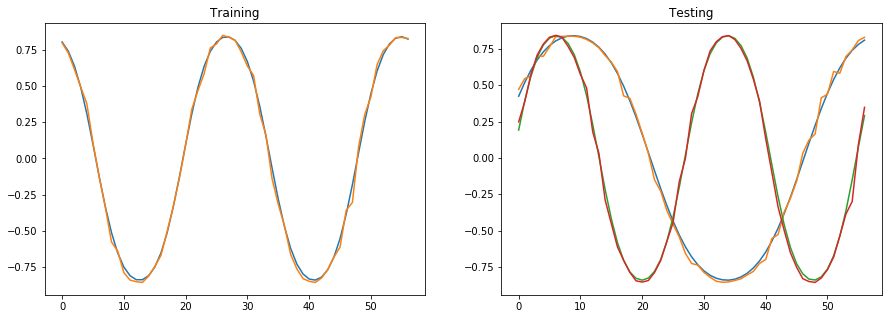

In [19]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

y_pred_train = model(X_train[0]).detach().numpy()
axis[0].plot(y_train[0], label='sin of actual angle')
axis[0].plot(y_pred_train, label='prediction')
axis[0].set_title(f"Training")

y_pred_test1 = model(X_test[0]).detach().numpy()
axis[1].plot(y_test[0], label='sin of actual angle')
axis[1].plot(y_pred_test1, label='prediction')
axis[1].set_title(f"Testing")

y_pred_test2 = model(X_test[1]).detach().numpy()
axis[1].plot(y_test[1], label='sin of actual angle')
axis[1].plot(y_pred_test2, label='prediction')
axis[1].set_title(f"Testing")

# Combine all the operations and display
plt.show()
print()

# Constant Velocity

In [3]:
# Original dataset angles; 1100 videos of 60 frames / angles each
all_angles = np.load("./circular_motion/all_angles.npy")
sin_angles = np.sin(all_angles)

# 110 test datapoints; 110 videos of 57 frames each = 6270 x 2 variables, 6270 x 1 ids
ids = np.load("/home/dmi/neural-state-variables/scripts/logs_circular_motion_refine-64_1/variables/ids.npy")
raw_vars = np.load("/home/dmi/neural-state-variables/scripts/logs_circular_motion_refine-64_1/variables/refine_latent.npy")
print(ids.shape)
print(raw_vars.shape)
print(all_angles.shape)

(6270,)
(6270, 2)
(1100, 60)


In [4]:
# print(ids[-100:])
# print(raw_vars[:57])


In [5]:
angles = all_angles[524]
print(angles.shape)
angles = angles[3:] # Ignore first 3 frames 
var1 = raw_vars[:57, 0]
var2 = raw_vars[:57, 1]
ids1 = ids[:57]
print(var1.shape)
print(angles.shape)
print(ids1)

(60,)
(57,)
(57,)
['524_0.png' '524_1.png' '524_2.png' '524_3.png' '524_4.png' '524_5.png'
 '524_6.png' '524_7.png' '524_8.png' '524_9.png' '524_10.png' '524_11.png'
 '524_12.png' '524_13.png' '524_14.png' '524_15.png' '524_16.png'
 '524_17.png' '524_18.png' '524_19.png' '524_20.png' '524_21.png'
 '524_22.png' '524_23.png' '524_24.png' '524_25.png' '524_26.png'
 '524_27.png' '524_28.png' '524_29.png' '524_30.png' '524_31.png'
 '524_32.png' '524_33.png' '524_34.png' '524_35.png' '524_36.png'
 '524_37.png' '524_38.png' '524_39.png' '524_40.png' '524_41.png'
 '524_42.png' '524_43.png' '524_44.png' '524_45.png' '524_46.png'
 '524_47.png' '524_48.png' '524_49.png' '524_50.png' '524_51.png'
 '524_52.png' '524_53.png' '524_54.png' '524_55.png' '524_56.png']


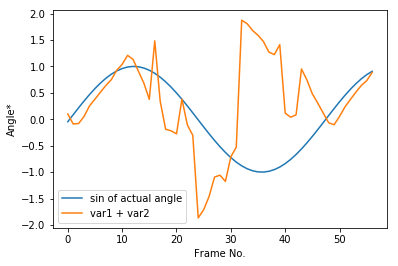

In [6]:
plt.plot(np.sin(angles), label='sin of actual angle')
# plt.plot(var1, label='predicted var 1')
# plt.plot(var2, label='predicted var 2')
# plt.plot(np.sin(var1))
# plt.plot(np.sin(var2))
var3 = var1 + var2
var4 = np.sin(var3)
plt.plot(var3, label='var1 + var2')
# plt.plot(var4, label='sin (var1 + var2)')
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.show()

# Neural Net
## Source: https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_vars = []
train_angles = []
train_ids = []

curr_id = -1
for i in range(0, len(ids), 57):
    set_id = int(ids[i].split("_")[0])
    a = all_angles[set_id][3:]
    v = raw_vars[i:i+57]
    
    train_ids.append(set_id)
    train_angles.append(a)
    train_vars.append(v)

In [9]:
X = np.array(train_vars)
y = np.array(train_angles)
train_ids = np.array(train_ids)
print(train_ids.shape)
print(np.array(X).shape)
print(np.array(y).shape)
print(X[0].shape)
print(X[0][:,0].shape)

(110,)
(110, 57, 2)
(110, 57)
(57, 2)
(57,)


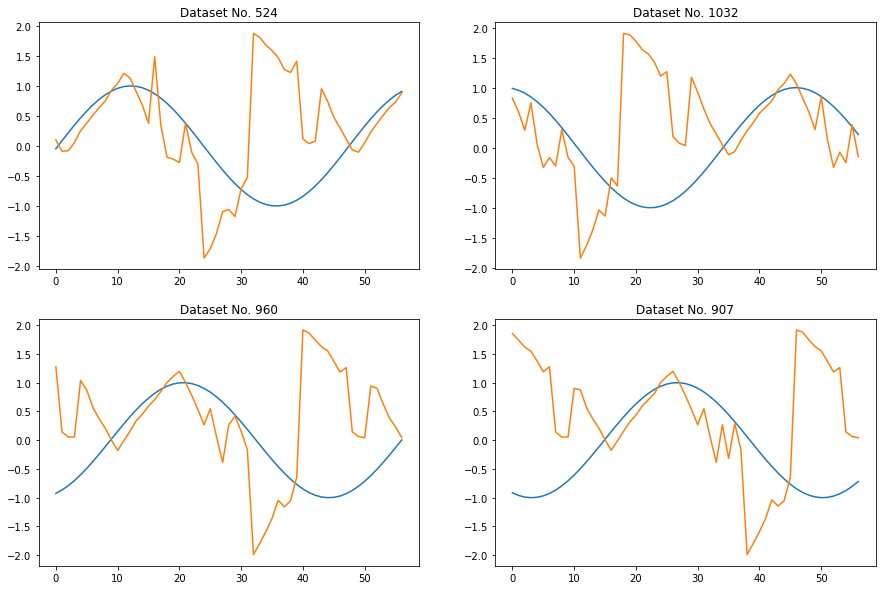

In [10]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 10))
  
axis[0, 0].plot(np.sin(y[0]), label="sin()")
# axis[0, 0].plot(X[0][:,0], label="var1")
# axis[0, 0].plot(X[0][:,1], label="var2")
axis[0, 0].plot(X[0][:,0] + X[0][:,1], label="var1 + var2")
axis[0, 0].set_title(f"Dataset No. {train_ids[0]}")

axis[0, 1].plot(np.sin(y[1]), label="sin()")
# axis[0, 1].plot(X[1][:,0], label="var1")
# axis[0, 1].plot(X[1][:,1], label="var2")
axis[0, 1].plot(X[1][:,0] + X[1][:,1], label="var1 + var2")
axis[0, 1].set_title(f"Dataset No. {train_ids[1]}")
  
axis[1, 0].plot(np.sin(y[2]), label="sin()")
# axis[1, 0].plot(X[2][:,0], label="var1")
# axis[1, 0].plot(X[2][:,1], label="var2")
axis[1, 0].plot(X[2][:,0] + X[2][:,1], label="var1 + var2")
axis[1, 0].set_title(f"Dataset No. {train_ids[2]}")
  
axis[1, 1].plot(np.sin(y[3]), label="sin()")
# axis[1, 1].plot(X[3][:,0], label="var1")
# axis[1, 1].plot(X[3][:,1], label="var2")
axis[1, 1].plot(X[3][:,0] + X[3][:,1], label="var1 + var2")
axis[1, 1].set_title(f"Dataset No. {train_ids[3]}")
  
# Combine all the operations and display
plt.show()

In [11]:
# Split into 108 training videos and 2 test videos
y = np.sin(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()
print(X_train[0].shape)
print(y_train[0].shape)
# print(X_train[0])

(108, 57, 2)
(108, 57)
(2, 57, 2)
(2, 57)
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([108, 57, 2])
torch.Size([108, 57])
torch.Size([2, 57, 2])
torch.Size([2, 57])

torch.Size([57, 2])
torch.Size([57])


(110, 57)
torch.Size([57, 2])
torch.Size([57])


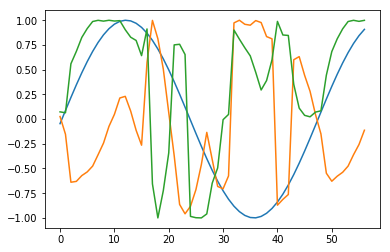

In [12]:
# x = torch.linspace(-math.pi, math.pi, 2000)
x = torch.linspace(-math.pi, math.pi, 57)
# x = torch.linspace(0, 2*math.pi, 60)
# print(x)
# y = torch.sin(x)
# print(y)

# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
# xx = x.unsqueeze(-1).pow(p)
xx = X_train[0]
print(y.shape)
print(xx.shape)
# print(xx)
plt.plot(y_train[0])
print(y_train[0].shape)
y = y_train[0]
plt.plot(xx)

## Training on one video (60 frames) only

In [13]:
import torch
import math


# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 30),
    nn.Tanh(),
    torch.nn.Linear(30, 60),
    nn.Tanh(),
    torch.nn.Linear(60, 1),
    torch.nn.Flatten(0, 1)
#     torch.nn.Linear(2, 30),
#     nn.Tanh(),
#     torch.nn.Linear(30, 60),
#     nn.Tanh(),
#     torch.nn.Linear(60, 30),
#     nn.Tanh(),
#     torch.nn.Linear(30, 1),
#     torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# y = y_train[0]
# x = X_train[0]

avg_loss = 0

for i in range(10000):
  # Get inputs
#     X = X_train
#     y = y_train
#     x = X_train[0]
#   y_pred = y_train[i].view(57,-1)
    
    # Forward pass: compute predicted y by passing x to the model.
#     print("X:", x)
#     print("Y:", y)
    
    y_pred = model(xx)
#     print("Ypred:", y_pred)
    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    avg_loss += loss.item()
    if i % 500 == 499:
        print(f"iter {i}; loss {loss.item()}, avg loss {avg_loss}")
        avg_loss = 0

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


# linear_layer = model[0]
# print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} var1 + {linear_layer.weight[:, 1].item()} var2')

iter 499; loss 2.2491321563720703, avg loss 2669.2500882148743
iter 999; loss 1.2962363958358765, avg loss 867.4521943330765
iter 1499; loss 0.9063999652862549, avg loss 548.7057657241821
iter 1999; loss 0.7311485409736633, avg loss 407.4066908955574
iter 2499; loss 0.47740787267684937, avg loss 293.2864352762699
iter 2999; loss 0.32552966475486755, avg loss 206.4634365439415
iter 3499; loss 0.21119394898414612, avg loss 139.50527746975422
iter 3999; loss 0.1494758427143097, avg loss 94.45830948650837
iter 4499; loss 0.11120955646038055, avg loss 70.65372524410486
iter 4999; loss 0.0776648074388504, avg loss 53.19563690572977
iter 5499; loss 0.08840686082839966, avg loss 39.64168135821819
iter 5999; loss 0.03984615579247475, avg loss 30.738763129338622
iter 6499; loss 0.04130597040057182, avg loss 24.353647520765662
iter 6999; loss 0.04819996654987335, avg loss 21.348690329119563
iter 7499; loss 0.02658856473863125, avg loss 19.056856567040086
iter 7999; loss 0.021814655512571335, avg 

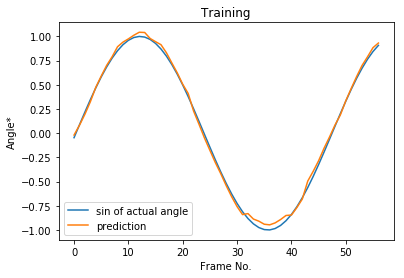

In [14]:
plt.plot(y, label='sin of actual angle')
plt.plot(y_pred.detach().numpy(), label='prediction')
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.title("Training")
plt.show()

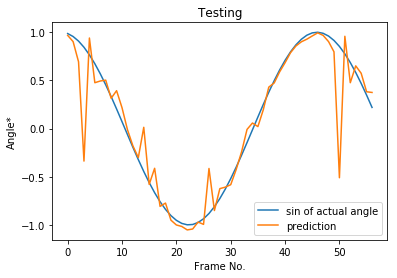

In [15]:
plt.plot(y_train[1], label='sin of actual angle')
plt.plot(model(X_train[1]).detach().numpy(), label='prediction')
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.title("Testing")
plt.show()

## Training using all videos

torch.Size([57])
torch.Size([57, 2])
torch.Size([57])


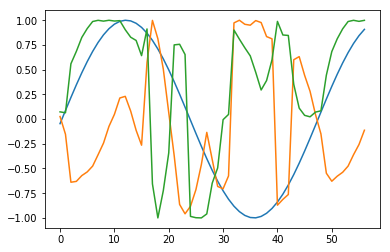

In [16]:
# x = torch.linspace(-math.pi, math.pi, 2000)
x = torch.linspace(-math.pi, math.pi, 57)
# x = torch.linspace(0, 2*math.pi, 60)
# print(x)
# y = torch.sin(x)
# print(y)

# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
# xx = x.unsqueeze(-1).pow(p)
xx = X_train[0]
print(y.shape)
print(xx.shape)
# print(xx)
plt.plot(y_train[0])
print(y_train[0].shape)
y = y_train[0]
plt.plot(xx)

In [17]:

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 30),
    nn.Tanh(),
    torch.nn.Linear(30, 60),
    nn.Tanh(),
    torch.nn.Linear(60, 30),
    nn.Tanh(),
    torch.nn.Linear(30, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

avg_loss = 0
for e in range(1000):
    for i in range(len(X_train)):
        # Get inputs
        y = y_train[i]
        x = X_train[i]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
        if i % 100 == 99:
            print(f"iter {i}; loss {loss.item()}, avg loss {avg_loss}")
            avg_loss = 0

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

iter 99; loss 5.933387756347656, avg loss 1653.8626337051392
iter 99; loss 4.250980854034424, avg loss 626.258189201355
iter 99; loss 3.806102991104126, avg loss 537.5666944980621
iter 99; loss 3.3395822048187256, avg loss 484.52006554603577
iter 99; loss 2.9014892578125, avg loss 436.33423829078674
iter 99; loss 2.5586700439453125, avg loss 396.42134046554565
iter 99; loss 2.2868599891662598, avg loss 363.42613768577576
iter 99; loss 2.0441999435424805, avg loss 333.19082283973694
iter 99; loss 1.814510703086853, avg loss 303.2154495716095
iter 99; loss 1.5885502099990845, avg loss 271.15855407714844
iter 99; loss 1.372170329093933, avg loss 239.0493607521057
iter 99; loss 1.138142466545105, avg loss 209.92966282367706
iter 99; loss 0.9525506496429443, avg loss 184.5450747013092
iter 99; loss 0.8274987936019897, avg loss 165.249470859766
iter 99; loss 0.7494851350784302, avg loss 150.78948193788528
iter 99; loss 0.705507755279541, avg loss 139.4559007883072
iter 99; loss 0.68372559547

iter 99; loss 0.03929819539189339, avg loss 4.783171551302075
iter 99; loss 0.039637625217437744, avg loss 4.739660203456879
iter 99; loss 0.03998897969722748, avg loss 4.697579619474709
iter 99; loss 0.040353622287511826, avg loss 4.656521363183856
iter 99; loss 0.04072849825024605, avg loss 4.616563277319074
iter 99; loss 0.041103117167949677, avg loss 4.577602346427739
iter 99; loss 0.041467782109975815, avg loss 4.539479253813624
iter 99; loss 0.04181933030486107, avg loss 4.502097485587001
iter 99; loss 0.04215966910123825, avg loss 4.4654342122375965
iter 99; loss 0.04247375950217247, avg loss 4.429583963938057
iter 99; loss 0.042686622589826584, avg loss 4.394468592479825
iter 99; loss 0.042799971997737885, avg loss 4.359556526876986
iter 99; loss 0.042802903801202774, avg loss 4.325099675916135
iter 99; loss 0.042707983404397964, avg loss 4.2905570631846786
iter 99; loss 0.042538732290267944, avg loss 4.255713848397136
iter 99; loss 0.04230822995305061, avg loss 4.2205821434035

iter 99; loss 0.08409499377012253, avg loss 1.7005937886424363
iter 99; loss 0.03563089668750763, avg loss 1.9004424177110195
iter 99; loss 0.04332076385617256, avg loss 1.799064563587308
iter 99; loss 0.05210932716727257, avg loss 1.7334984904155135
iter 99; loss 0.044257067143917084, avg loss 1.8035053675994277
iter 99; loss 0.04667261987924576, avg loss 1.8607074059545994
iter 99; loss 0.053895529359579086, avg loss 1.7596112457104027
iter 99; loss 0.021371876820921898, avg loss 1.658146375324577
iter 99; loss 0.008430280722677708, avg loss 1.9260157574899495
iter 99; loss 0.015168356709182262, avg loss 1.82362407958135
iter 99; loss 0.026520881801843643, avg loss 1.5106604974716902
iter 99; loss 0.015513898804783821, avg loss 1.9518847577273846
iter 99; loss 0.017818260937929153, avg loss 1.7223824905231595
iter 99; loss 0.004653517622500658, avg loss 1.8057581442408264
iter 99; loss 0.025928940623998642, avg loss 1.7384383771568537
iter 99; loss 0.009139878675341606, avg loss 1.41

iter 99; loss 0.004049339797347784, avg loss 1.3268015265930444
iter 99; loss 0.004075419623404741, avg loss 1.3239262434653938
iter 99; loss 0.004128580912947655, avg loss 1.320474966429174
iter 99; loss 0.0042227222584187984, avg loss 1.3161664032377303
iter 99; loss 0.004368639085441828, avg loss 1.310006660176441
iter 99; loss 0.004433422815054655, avg loss 1.30127985146828
iter 99; loss 0.003871017601341009, avg loss 1.2961586192250252
iter 99; loss 0.0028278238605707884, avg loss 1.31767748715356
iter 99; loss 0.003332825843244791, avg loss 1.2538555737119168
iter 99; loss 0.004490745719522238, avg loss 1.2684777341783047
iter 99; loss 0.023124059662222862, avg loss 1.3691693900618702
iter 99; loss 0.004571837373077869, avg loss 1.2943176971748471
iter 99; loss 0.011305984109640121, avg loss 1.2669879863969982
iter 99; loss 0.026228781789541245, avg loss 1.3663924420252442
iter 99; loss 0.009064827114343643, avg loss 1.3243398475460708
iter 99; loss 0.012841187417507172, avg loss

iter 99; loss 0.008125386200845242, avg loss 1.3434760682284832
iter 99; loss 0.013092612847685814, avg loss 1.0354136407840997
iter 99; loss 0.060134947299957275, avg loss 1.21770745748654
iter 99; loss 0.025903144851326942, avg loss 1.0269847839372233
iter 99; loss 0.03516753017902374, avg loss 1.1769674555398524
iter 99; loss 0.03751648589968681, avg loss 1.0946243803482503
iter 99; loss 0.032805055379867554, avg loss 1.0990323382429779
iter 99; loss 0.027800582349300385, avg loss 1.1733111743815243
iter 99; loss 0.05067070573568344, avg loss 1.143103696173057
iter 99; loss 0.02771545574069023, avg loss 1.0642937204102054
iter 99; loss 0.010833678767085075, avg loss 1.2812081829179078
iter 99; loss 0.014928304590284824, avg loss 1.0477320230565965
iter 99; loss 0.05695248022675514, avg loss 1.2038342743180692
iter 99; loss 0.027756158262491226, avg loss 1.035921630449593
iter 99; loss 0.0393940769135952, avg loss 1.1456048430409282
iter 99; loss 0.03720782697200775, avg loss 1.08849

iter 99; loss 0.026167741045355797, avg loss 0.9352012197487056
iter 99; loss 0.03771501034498215, avg loss 1.0161256187129766
iter 99; loss 0.0248438511043787, avg loss 0.9715606842655689
iter 99; loss 0.04304536432027817, avg loss 1.069888015743345
iter 99; loss 0.02188606560230255, avg loss 0.9508134094066918
iter 99; loss 0.029512466862797737, avg loss 1.077279777964577
iter 99; loss 0.047966551035642624, avg loss 0.9901739025954157
iter 99; loss 0.023041024804115295, avg loss 0.9692158265970647
iter 99; loss 0.040148817002773285, avg loss 1.0580464585218579
iter 99; loss 0.024043135344982147, avg loss 0.9335620293859392
iter 99; loss 0.04072542488574982, avg loss 1.0231790996622294
iter 99; loss 0.027059661224484444, avg loss 0.9635192935820669
iter 99; loss 0.04534155875444412, avg loss 1.0316435766872019
iter 99; loss 0.021689970046281815, avg loss 0.9527824379038066
iter 99; loss 0.022901736199855804, avg loss 1.0824870634824038
iter 99; loss 0.03729800134897232, avg loss 1.024

iter 99; loss 0.02089708298444748, avg loss 0.8930548008065671
iter 99; loss 0.024837937206029892, avg loss 0.9619650782551616
iter 99; loss 0.01579239033162594, avg loss 0.8806572733446956
iter 99; loss 0.03612930700182915, avg loss 0.9682967222761363
iter 99; loss 0.01713043823838234, avg loss 0.8819246721686795
iter 99; loss 0.015473952516913414, avg loss 0.9772667358629405
iter 99; loss 0.01137967873364687, avg loss 0.9106786465272307
iter 99; loss 0.01260396372526884, avg loss 0.9101348984986544
iter 99; loss 0.005748659837990999, avg loss 0.7971476225648075
iter 99; loss 0.02778634801506996, avg loss 1.0308506933506578
iter 99; loss 0.020294882357120514, avg loss 0.8341147715691477
iter 99; loss 0.041301000863313675, avg loss 0.9612626642920077
iter 99; loss 0.024672359228134155, avg loss 0.9357721006963402
iter 99; loss 0.03831500932574272, avg loss 0.9365958701819181
iter 99; loss 0.023437801748514175, avg loss 0.9015758885070682
iter 99; loss 0.028026532381772995, avg loss 0.9

iter 99; loss 0.01779910922050476, avg loss 0.839004858629778
iter 99; loss 0.03905962035059929, avg loss 0.9071965720504522
iter 99; loss 0.019980870187282562, avg loss 0.856750980601646
iter 99; loss 0.041278719902038574, avg loss 0.886916407616809
iter 99; loss 0.016129223629832268, avg loss 0.8663238737499341
iter 99; loss 0.03693308308720589, avg loss 0.8964505733456463
iter 99; loss 0.018127962946891785, avg loss 0.8514982052147388
iter 99; loss 0.035374581813812256, avg loss 0.8976617665030062
iter 99; loss 0.015630671754479408, avg loss 0.8483936080010608
iter 99; loss 0.031259167939424515, avg loss 0.8992182572837919
iter 99; loss 0.014890654012560844, avg loss 0.8391182679915801
iter 99; loss 0.03383829817175865, avg loss 0.9023894788697362
iter 99; loss 0.01671821065247059, avg loss 0.8342607807135209
iter 99; loss 0.039774034172296524, avg loss 0.9045663953293115
iter 99; loss 0.01744946278631687, avg loss 0.8425516177667305
iter 99; loss 0.04044244438409805, avg loss 0.893

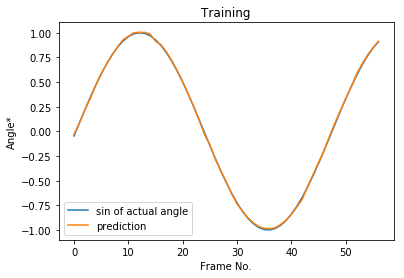

Training Loss: 0.004729539155960083


In [18]:
plt.plot(y_train[0], label='sin of actual angle')
y_pred = model(X_train[0])
plt.plot(y_pred.detach().numpy(), label='prediction')
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.title("Training")
plt.show()
print("Training Loss:", loss_fn(y_pred, y_train[0]).item())

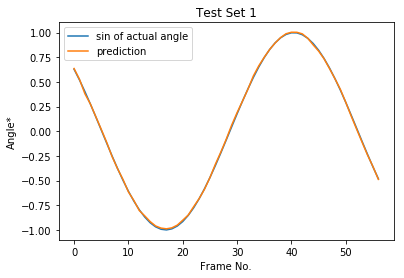

Test Loss 1: 0.004151606000959873


In [19]:
plt.plot(y_test[0], label='sin of actual angle')
y_pred = model(X_test[0])
plt.plot(y_pred.detach().numpy(), label='prediction')
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.title("Test Set 1")
plt.show()
print("Test Loss 1:", loss_fn(y_pred, y_test[0]).item())

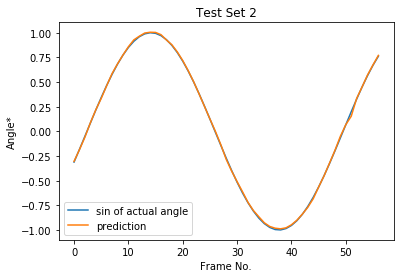

Test Loss 2: 0.0051490748301148415


In [20]:
plt.plot(y_test[1], label='sin of actual angle')
y_pred = model(X_test[1])
plt.plot(y_pred.detach().numpy(), label='prediction')
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.title("Test Set 2")
plt.show()
print("Test Loss 2:", loss_fn(y_pred, y_test[1]).item())

## Simpler Network

In [32]:
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    nn.Tanh(),
    torch.nn.Linear(5, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for e in range(1000):
    avg_loss = 0
    for i in range(len(X_train)):
        # Get inputs
        y = y_train[i]
        x = X_train[i]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
#         if e % 10 == 9:
#             print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
#             avg_loss = 0

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
    avg_loss = 0

epoch 0; loss 3.047515869140625, avg loss 66660.63916993141
epoch 1; loss 3.719527006149292, avg loss 3.719527006149292
epoch 2; loss 2.9834420680999756, avg loss 2.9834420680999756
epoch 3; loss 3.0047812461853027, avg loss 3.0047812461853027
epoch 4; loss 3.0383460521698, avg loss 3.0383460521698
epoch 5; loss 3.5718066692352295, avg loss 3.5718066692352295
epoch 6; loss 3.6813406944274902, avg loss 3.6813406944274902
epoch 7; loss 7.105454921722412, avg loss 7.105454921722412
epoch 8; loss 3.644014596939087, avg loss 3.644014596939087
epoch 9; loss 3.3316383361816406, avg loss 3.3316383361816406
epoch 10; loss 6.879392623901367, avg loss 6.879392623901367
epoch 11; loss 3.292219877243042, avg loss 3.292219877243042
epoch 12; loss 3.4520955085754395, avg loss 3.4520955085754395
epoch 13; loss 3.8679332733154297, avg loss 3.8679332733154297
epoch 14; loss 2.499335527420044, avg loss 2.499335527420044
epoch 15; loss 3.016578435897827, avg loss 3.016578435897827
epoch 16; loss 3.5197679

epoch 0; loss 2.3520138263702393, avg loss 35964.360983133316
epoch 1; loss 2.941192865371704, avg loss 2.941192865371704
epoch 2; loss 1.9452136754989624, avg loss 1.9452136754989624
epoch 3; loss 2.016207695007324, avg loss 2.016207695007324
epoch 4; loss 2.9571166038513184, avg loss 2.9571166038513184
epoch 5; loss 2.765350341796875, avg loss 2.765350341796875
epoch 6; loss 3.192418336868286, avg loss 3.192418336868286
epoch 7; loss 6.781502723693848, avg loss 6.781502723693848
epoch 8; loss 2.9458072185516357, avg loss 2.9458072185516357
epoch 9; loss 2.983794689178467, avg loss 2.983794689178467
epoch 10; loss 6.788666725158691, avg loss 6.788666725158691
epoch 11; loss 2.927671432495117, avg loss 2.927671432495117
epoch 12; loss 2.441908597946167, avg loss 2.441908597946167
epoch 13; loss 3.251035690307617, avg loss 3.251035690307617
epoch 14; loss 1.9009283781051636, avg loss 1.9009283781051636
epoch 15; loss 2.524829864501953, avg loss 2.524829864501953
epoch 16; loss 3.3461382

epoch 0; loss 2.2370638847351074, avg loss 33707.20074951649
epoch 1; loss 2.825502395629883, avg loss 2.825502395629883
epoch 2; loss 1.7300361394882202, avg loss 1.7300361394882202
epoch 3; loss 1.8760379552841187, avg loss 1.8760379552841187
epoch 4; loss 2.882089376449585, avg loss 2.882089376449585
epoch 5; loss 2.625875949859619, avg loss 2.625875949859619
epoch 6; loss 3.101882219314575, avg loss 3.101882219314575
epoch 7; loss 6.505878448486328, avg loss 6.505878448486328
epoch 8; loss 2.785449266433716, avg loss 2.785449266433716
epoch 9; loss 2.8345320224761963, avg loss 2.8345320224761963
epoch 10; loss 6.711273193359375, avg loss 6.711273193359375
epoch 11; loss 2.8069918155670166, avg loss 2.8069918155670166
epoch 12; loss 2.2359206676483154, avg loss 2.2359206676483154
epoch 13; loss 3.093937873840332, avg loss 3.093937873840332
epoch 14; loss 1.8242440223693848, avg loss 1.8242440223693848
epoch 15; loss 2.5053837299346924, avg loss 2.5053837299346924
epoch 16; loss 3.19

epoch 0; loss 2.192903995513916, avg loss 33074.84186351299
epoch 1; loss 2.77034854888916, avg loss 2.77034854888916
epoch 2; loss 1.6710774898529053, avg loss 1.6710774898529053
epoch 3; loss 1.8174622058868408, avg loss 1.8174622058868408
epoch 4; loss 2.8237574100494385, avg loss 2.8237574100494385
epoch 5; loss 2.562562942504883, avg loss 2.562562942504883
epoch 6; loss 3.018944501876831, avg loss 3.018944501876831
epoch 7; loss 6.435340404510498, avg loss 6.435340404510498
epoch 8; loss 2.7286605834960938, avg loss 2.7286605834960938
epoch 9; loss 2.7635321617126465, avg loss 2.7635321617126465
epoch 10; loss 6.652830123901367, avg loss 6.652830123901367
epoch 11; loss 2.7422990798950195, avg loss 2.7422990798950195
epoch 12; loss 2.189882516860962, avg loss 2.189882516860962
epoch 13; loss 3.0232889652252197, avg loss 3.0232889652252197
epoch 14; loss 1.7771722078323364, avg loss 1.7771722078323364
epoch 15; loss 2.4676434993743896, avg loss 2.4676434993743896
epoch 16; loss 3.1

epoch 0; loss 2.1391868591308594, avg loss 32479.151274442673
epoch 1; loss 2.7218613624572754, avg loss 2.7218613624572754
epoch 2; loss 1.621949553489685, avg loss 1.621949553489685
epoch 3; loss 1.761883020401001, avg loss 1.761883020401001
epoch 4; loss 2.777036428451538, avg loss 2.777036428451538
epoch 5; loss 2.4896368980407715, avg loss 2.4896368980407715
epoch 6; loss 2.934723377227783, avg loss 2.934723377227783
epoch 7; loss 6.413694381713867, avg loss 6.413694381713867
epoch 8; loss 2.675410270690918, avg loss 2.675410270690918
epoch 9; loss 2.6915228366851807, avg loss 2.6915228366851807
epoch 10; loss 6.593822002410889, avg loss 6.593822002410889
epoch 11; loss 2.6765270233154297, avg loss 2.6765270233154297
epoch 12; loss 2.1579854488372803, avg loss 2.1579854488372803
epoch 13; loss 2.9736456871032715, avg loss 2.9736456871032715
epoch 14; loss 1.7240650653839111, avg loss 1.7240650653839111
epoch 15; loss 2.4108381271362305, avg loss 2.4108381271362305
epoch 16; loss 3

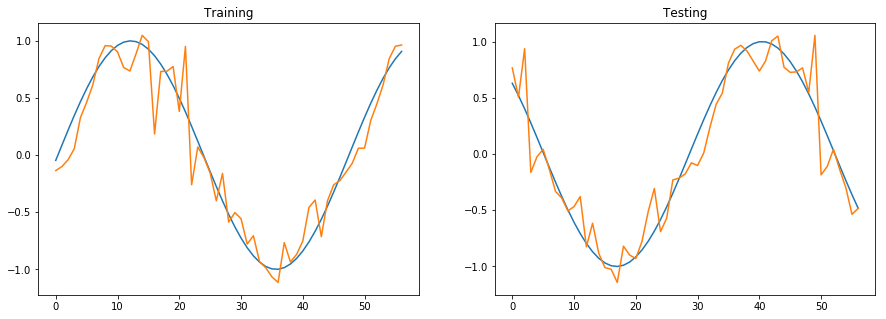

In [34]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

y_pred_train = model(X_train[0]).detach().numpy()
axis[0].plot(y_train[0], label='sin of actual angle')
axis[0].plot(y_pred_train, label='prediction')
axis[0].set_title(f"Training")

y_pred_test = model(X_test[0]).detach().numpy()
axis[1].plot(y_test[0], label='sin of actual angle')
axis[1].plot(y_pred_test, label='prediction')
axis[1].set_title(f"Testing")

# Combine all the operations and display
plt.show()
print()

In [36]:
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    nn.Tanh(),
    torch.nn.Linear(5, 10),
    nn.Tanh(),
    torch.nn.Linear(10, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for e in range(1000):
    avg_loss = 0
    for i in range(len(X_train)):
        # Get inputs
        y = y_train[i]
        x = X_train[i]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
#         if e % 10 == 9:
#             print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
#             avg_loss = 0

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
    avg_loss = 0

epoch 0; loss 29.55575180053711, avg loss 3073.667869567871
epoch 1; loss 27.217424392700195, avg loss 2859.2743072509766
epoch 2; loss 24.7697811126709, avg loss 2692.100275039673
epoch 3; loss 21.3618106842041, avg loss 2437.3680114746094
epoch 4; loss 16.709003448486328, avg loss 2041.1252918243408
epoch 5; loss 11.708698272705078, avg loss 1542.7818689346313
epoch 6; loss 7.991347789764404, avg loss 1102.400628566742
epoch 7; loss 6.0975847244262695, avg loss 845.4946479797363
epoch 8; loss 5.196961879730225, avg loss 727.7229056358337
epoch 9; loss 4.653378486633301, avg loss 661.3442363739014
epoch 10; loss 4.304589748382568, avg loss 616.7819399833679
epoch 11; loss 4.089279651641846, avg loss 587.9322366714478
epoch 12; loss 3.949150323867798, avg loss 568.8780131340027
epoch 13; loss 3.8446216583251953, avg loss 554.5174822807312
epoch 14; loss 3.7567689418792725, avg loss 542.2794599533081
epoch 15; loss 3.67765474319458, avg loss 531.2264382839203
epoch 16; loss 3.6039154529

epoch 132; loss 0.7019152641296387, avg loss 155.2955910563469
epoch 133; loss 0.6933742165565491, avg loss 154.39521765708923
epoch 134; loss 0.6850335597991943, avg loss 153.51306408643723
epoch 135; loss 0.6768776178359985, avg loss 152.64765125513077
epoch 136; loss 0.6688953042030334, avg loss 151.79735788702965
epoch 137; loss 0.6610750555992126, avg loss 150.96054443717003
epoch 138; loss 0.6534038782119751, avg loss 150.1354924440384
epoch 139; loss 0.6458712816238403, avg loss 149.32045236229897
epoch 140; loss 0.6384662985801697, avg loss 148.5137114226818
epoch 141; loss 0.6311787366867065, avg loss 147.71355146169662
epoch 142; loss 0.6239972114562988, avg loss 146.91832274198532
epoch 143; loss 0.6169105172157288, avg loss 146.1264640390873
epoch 144; loss 0.6099106073379517, avg loss 145.3364634513855
epoch 145; loss 0.6029883027076721, avg loss 144.5469560623169
epoch 146; loss 0.5961358547210693, avg loss 143.75667417049408
epoch 147; loss 0.5893402695655823, avg loss 1

epoch 262; loss 0.32570385932922363, avg loss 93.66126163303852
epoch 263; loss 0.3253602683544159, avg loss 93.51263822615147
epoch 264; loss 0.325018972158432, avg loss 93.36682611703873
epoch 265; loss 0.324678510427475, avg loss 93.22376683354378
epoch 266; loss 0.32434171438217163, avg loss 93.08341260254383
epoch 267; loss 0.3240063488483429, avg loss 92.94572141766548
epoch 268; loss 0.3236720860004425, avg loss 92.81063249707222
epoch 269; loss 0.3233391046524048, avg loss 92.67810116708279
epoch 270; loss 0.3230074346065521, avg loss 92.54807148873806
epoch 271; loss 0.32267725467681885, avg loss 92.42048831284046
epoch 272; loss 0.3223482072353363, avg loss 92.29530707001686
epoch 273; loss 0.3220192790031433, avg loss 92.17245456576347
epoch 274; loss 0.3216920793056488, avg loss 92.05190692842007
epoch 275; loss 0.3213655352592468, avg loss 91.93358370661736
epoch 276; loss 0.3210400342941284, avg loss 91.81745326519012
epoch 277; loss 0.3207152783870697, avg loss 91.703453

epoch 392; loss 0.2921043932437897, avg loss 85.21772445738316
epoch 393; loss 0.29191410541534424, avg loss 85.18601267039776
epoch 394; loss 0.29172617197036743, avg loss 85.15445548295975
epoch 395; loss 0.291537344455719, avg loss 85.12306386232376
epoch 396; loss 0.29135093092918396, avg loss 85.09182991087437
epoch 397; loss 0.2911640405654907, avg loss 85.06074073910713
epoch 398; loss 0.2909780740737915, avg loss 85.02980634570122
epoch 399; loss 0.2907930016517639, avg loss 84.99901375174522
epoch 400; loss 0.2906087040901184, avg loss 84.96837085485458
epoch 401; loss 0.2904259264469147, avg loss 84.9378614127636
epoch 402; loss 0.29024291038513184, avg loss 84.9074888676405
epoch 403; loss 0.2900611460208893, avg loss 84.87725357711315
epoch 404; loss 0.2898803949356079, avg loss 84.84715335071087
epoch 405; loss 0.2896997630596161, avg loss 84.81716467440128
epoch 406; loss 0.28951993584632874, avg loss 84.7873161137104
epoch 407; loss 0.28934091329574585, avg loss 84.75758

epoch 522; loss 0.27187463641166687, avg loss 81.68249110877514
epoch 523; loss 0.2717352509498596, avg loss 81.65704397857189
epoch 524; loss 0.2715967297554016, avg loss 81.63163331151009
epoch 525; loss 0.27145859599113464, avg loss 81.60624250769615
epoch 526; loss 0.27131980657577515, avg loss 81.58088855445385
epoch 527; loss 0.2711821496486664, avg loss 81.55557098984718
epoch 528; loss 0.2710438072681427, avg loss 81.53028433024883
epoch 529; loss 0.270906001329422, avg loss 81.50502881407738
epoch 530; loss 0.27076852321624756, avg loss 81.47981564700603
epoch 531; loss 0.27063125371932983, avg loss 81.45464533567429
epoch 532; loss 0.2704942226409912, avg loss 81.42949737608433
epoch 533; loss 0.27035650610923767, avg loss 81.40439729392529
epoch 534; loss 0.27021992206573486, avg loss 81.37933380901814
epoch 535; loss 0.27008330821990967, avg loss 81.35430908203125
epoch 536; loss 0.26994648575782776, avg loss 81.32932186126709
epoch 537; loss 0.26980990171432495, avg loss 8

epoch 652; loss 0.2567559480667114, avg loss 78.81668841838837
epoch 653; loss 0.2566785216331482, avg loss 78.79826393723488
epoch 654; loss 0.2566028833389282, avg loss 78.7798752784729
epoch 655; loss 0.2565276026725769, avg loss 78.76152841746807
epoch 656; loss 0.2564528286457062, avg loss 78.74322032928467
epoch 657; loss 0.25637978315353394, avg loss 78.72495776414871
epoch 658; loss 0.256306916475296, avg loss 78.70671823620796
epoch 659; loss 0.2562349736690521, avg loss 78.68852707743645
epoch 660; loss 0.2561633884906769, avg loss 78.67037191987038
epoch 661; loss 0.2560938000679016, avg loss 78.65224425494671
epoch 662; loss 0.25602424144744873, avg loss 78.63416258990765
epoch 663; loss 0.25595623254776, avg loss 78.61611768603325
epoch 664; loss 0.2558883726596832, avg loss 78.5981004089117
epoch 665; loss 0.25582215189933777, avg loss 78.58011336624622
epoch 666; loss 0.2557564973831177, avg loss 78.56216253340244
epoch 667; loss 0.2556914687156677, avg loss 78.544249206

epoch 782; loss 0.25315508246421814, avg loss 76.55130387842655
epoch 783; loss 0.2531680166721344, avg loss 76.5329227745533
epoch 784; loss 0.2531827986240387, avg loss 76.51446545124054
epoch 785; loss 0.25319772958755493, avg loss 76.49593232572079
epoch 786; loss 0.2532138228416443, avg loss 76.47730927169323
epoch 787; loss 0.2532307207584381, avg loss 76.45859365165234
epoch 788; loss 0.25324922800064087, avg loss 76.43978148698807
epoch 789; loss 0.2532689869403839, avg loss 76.4208724796772
epoch 790; loss 0.25329023599624634, avg loss 76.40185780823231
epoch 791; loss 0.25331196188926697, avg loss 76.38273048400879
epoch 792; loss 0.2533358335494995, avg loss 76.36348932981491
epoch 793; loss 0.2533603012561798, avg loss 76.34411878883839
epoch 794; loss 0.253386527299881, avg loss 76.32461167871952
epoch 795; loss 0.253414511680603, avg loss 76.30497193336487
epoch 796; loss 0.2534450590610504, avg loss 76.28516654670238
epoch 797; loss 0.2534763216972351, avg loss 76.265218

epoch 912; loss 0.24947774410247803, avg loss 74.20015767216682
epoch 913; loss 0.24944525957107544, avg loss 74.18609774112701
epoch 914; loss 0.24941515922546387, avg loss 74.17206901311874
epoch 915; loss 0.24938485026359558, avg loss 74.15805639326572
epoch 916; loss 0.24935530126094818, avg loss 74.14406861364841
epoch 917; loss 0.24932505190372467, avg loss 74.1301041841507
epoch 918; loss 0.24929647147655487, avg loss 74.11616607010365
epoch 919; loss 0.2492678165435791, avg loss 74.10224634408951
epoch 920; loss 0.2492395043373108, avg loss 74.0883584022522
epoch 921; loss 0.24921073019504547, avg loss 74.07448306679726
epoch 922; loss 0.2491835653781891, avg loss 74.0606445223093
epoch 923; loss 0.24915602803230286, avg loss 74.04681846499443
epoch 924; loss 0.2491293102502823, avg loss 74.03301180899143
epoch 925; loss 0.2491026371717453, avg loss 74.01922954618931
epoch 926; loss 0.24907614290714264, avg loss 74.00546272099018
epoch 927; loss 0.24905076622962952, avg loss 73

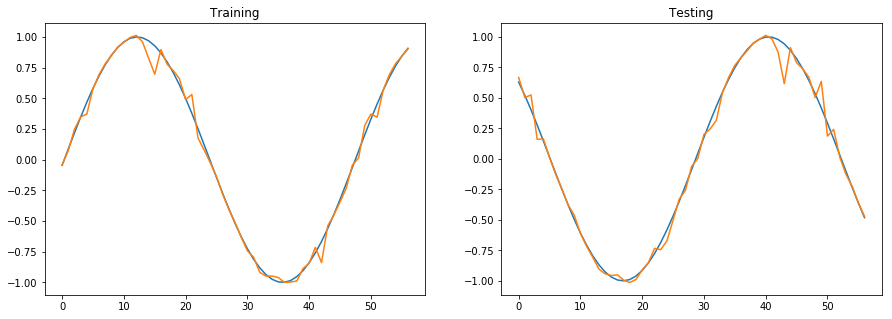

In [37]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

y_pred_train = model(X_train[0]).detach().numpy()
axis[0].plot(y_train[0], label='sin of actual angle')
axis[0].plot(y_pred_train, label='prediction')
axis[0].set_title(f"Training")

y_pred_test = model(X_test[0]).detach().numpy()
axis[1].plot(y_test[0], label='sin of actual angle')
axis[1].plot(y_pred_test, label='prediction')
axis[1].set_title(f"Testing")

# Combine all the operations and display
plt.show()
print()

In [41]:
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for e in range(1000):
    avg_loss = 0
    for i in range(len(X_train)):
        # Get inputs
        y = y_train[i]
        x = X_train[i]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
#         if e % 10 == 9:
#             print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
#             avg_loss = 0

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
    avg_loss = 0

epoch 0; loss 41.365291595458984, avg loss 4270.449424743652
epoch 1; loss 34.759098052978516, avg loss 3499.3466358184814
epoch 2; loss 31.367549896240234, avg loss 3182.7685947418213
epoch 3; loss 29.682064056396484, avg loss 3024.336753845215
epoch 4; loss 28.925865173339844, avg loss 2943.812391281128
epoch 5; loss 28.636398315429688, avg loss 2905.618528366089
epoch 6; loss 28.552392959594727, avg loss 2890.72043800354
epoch 7; loss 28.539194107055664, avg loss 2886.4672622680664
epoch 8; loss 28.542484283447266, avg loss 2885.6012802124023
epoch 9; loss 28.54729461669922, avg loss 2885.453025817871
epoch 10; loss 28.550888061523438, avg loss 2885.4235515594482
epoch 11; loss 28.553205490112305, avg loss 2885.415273666382
epoch 12; loss 28.554615020751953, avg loss 2885.4122734069824
epoch 13; loss 28.55544662475586, avg loss 2885.4110355377197
epoch 14; loss 28.555932998657227, avg loss 2885.410472869873
epoch 15; loss 28.55621337890625, avg loss 2885.4101791381836
epoch 16; loss

epoch 133; loss 28.556591033935547, avg loss 2885.409860610962
epoch 134; loss 28.556591033935547, avg loss 2885.409860610962
epoch 135; loss 28.556591033935547, avg loss 2885.409860610962
epoch 136; loss 28.556591033935547, avg loss 2885.409860610962
epoch 137; loss 28.556591033935547, avg loss 2885.409860610962
epoch 138; loss 28.556591033935547, avg loss 2885.409860610962
epoch 139; loss 28.556591033935547, avg loss 2885.409860610962
epoch 140; loss 28.556591033935547, avg loss 2885.409860610962
epoch 141; loss 28.556591033935547, avg loss 2885.409860610962
epoch 142; loss 28.556591033935547, avg loss 2885.409860610962
epoch 143; loss 28.556591033935547, avg loss 2885.409860610962
epoch 144; loss 28.556591033935547, avg loss 2885.409860610962
epoch 145; loss 28.556591033935547, avg loss 2885.409860610962
epoch 146; loss 28.556591033935547, avg loss 2885.409860610962
epoch 147; loss 28.556591033935547, avg loss 2885.409860610962
epoch 148; loss 28.556591033935547, avg loss 2885.40986

epoch 268; loss 28.556591033935547, avg loss 2885.409860610962
epoch 269; loss 28.556591033935547, avg loss 2885.409860610962
epoch 270; loss 28.556591033935547, avg loss 2885.409860610962
epoch 271; loss 28.556591033935547, avg loss 2885.409860610962
epoch 272; loss 28.556591033935547, avg loss 2885.409860610962
epoch 273; loss 28.556591033935547, avg loss 2885.409860610962
epoch 274; loss 28.556591033935547, avg loss 2885.409860610962
epoch 275; loss 28.556591033935547, avg loss 2885.409860610962
epoch 276; loss 28.556591033935547, avg loss 2885.409860610962
epoch 277; loss 28.556591033935547, avg loss 2885.409860610962
epoch 278; loss 28.556591033935547, avg loss 2885.409860610962
epoch 279; loss 28.556591033935547, avg loss 2885.409860610962
epoch 280; loss 28.556591033935547, avg loss 2885.409860610962
epoch 281; loss 28.556591033935547, avg loss 2885.409860610962
epoch 282; loss 28.556591033935547, avg loss 2885.409860610962
epoch 283; loss 28.556591033935547, avg loss 2885.40986

epoch 402; loss 28.556591033935547, avg loss 2885.409860610962
epoch 403; loss 28.556591033935547, avg loss 2885.409860610962
epoch 404; loss 28.556591033935547, avg loss 2885.409860610962
epoch 405; loss 28.556591033935547, avg loss 2885.409860610962
epoch 406; loss 28.556591033935547, avg loss 2885.409860610962
epoch 407; loss 28.556591033935547, avg loss 2885.409860610962
epoch 408; loss 28.556591033935547, avg loss 2885.409860610962
epoch 409; loss 28.556591033935547, avg loss 2885.409860610962
epoch 410; loss 28.556591033935547, avg loss 2885.409860610962
epoch 411; loss 28.556591033935547, avg loss 2885.409860610962
epoch 412; loss 28.556591033935547, avg loss 2885.409860610962
epoch 413; loss 28.556591033935547, avg loss 2885.409860610962
epoch 414; loss 28.556591033935547, avg loss 2885.409860610962
epoch 415; loss 28.556591033935547, avg loss 2885.409860610962
epoch 416; loss 28.556591033935547, avg loss 2885.409860610962
epoch 417; loss 28.556591033935547, avg loss 2885.40986

epoch 535; loss 28.556591033935547, avg loss 2885.409860610962
epoch 536; loss 28.556591033935547, avg loss 2885.409860610962
epoch 537; loss 28.556591033935547, avg loss 2885.409860610962
epoch 538; loss 28.556591033935547, avg loss 2885.409860610962
epoch 539; loss 28.556591033935547, avg loss 2885.409860610962
epoch 540; loss 28.556591033935547, avg loss 2885.409860610962
epoch 541; loss 28.556591033935547, avg loss 2885.409860610962
epoch 542; loss 28.556591033935547, avg loss 2885.409860610962
epoch 543; loss 28.556591033935547, avg loss 2885.409860610962
epoch 544; loss 28.556591033935547, avg loss 2885.409860610962
epoch 545; loss 28.556591033935547, avg loss 2885.409860610962
epoch 546; loss 28.556591033935547, avg loss 2885.409860610962
epoch 547; loss 28.556591033935547, avg loss 2885.409860610962
epoch 548; loss 28.556591033935547, avg loss 2885.409860610962
epoch 549; loss 28.556591033935547, avg loss 2885.409860610962
epoch 550; loss 28.556591033935547, avg loss 2885.40986

epoch 669; loss 28.556591033935547, avg loss 2885.409860610962
epoch 670; loss 28.556591033935547, avg loss 2885.409860610962
epoch 671; loss 28.556591033935547, avg loss 2885.409860610962
epoch 672; loss 28.556591033935547, avg loss 2885.409860610962
epoch 673; loss 28.556591033935547, avg loss 2885.409860610962
epoch 674; loss 28.556591033935547, avg loss 2885.409860610962
epoch 675; loss 28.556591033935547, avg loss 2885.409860610962
epoch 676; loss 28.556591033935547, avg loss 2885.409860610962
epoch 677; loss 28.556591033935547, avg loss 2885.409860610962
epoch 678; loss 28.556591033935547, avg loss 2885.409860610962
epoch 679; loss 28.556591033935547, avg loss 2885.409860610962
epoch 680; loss 28.556591033935547, avg loss 2885.409860610962
epoch 681; loss 28.556591033935547, avg loss 2885.409860610962
epoch 682; loss 28.556591033935547, avg loss 2885.409860610962
epoch 683; loss 28.556591033935547, avg loss 2885.409860610962
epoch 684; loss 28.556591033935547, avg loss 2885.40986

epoch 800; loss 28.556591033935547, avg loss 2885.409860610962
epoch 801; loss 28.556591033935547, avg loss 2885.409860610962
epoch 802; loss 28.556591033935547, avg loss 2885.409860610962
epoch 803; loss 28.556591033935547, avg loss 2885.409860610962
epoch 804; loss 28.556591033935547, avg loss 2885.409860610962
epoch 805; loss 28.556591033935547, avg loss 2885.409860610962
epoch 806; loss 28.556591033935547, avg loss 2885.409860610962
epoch 807; loss 28.556591033935547, avg loss 2885.409860610962
epoch 808; loss 28.556591033935547, avg loss 2885.409860610962
epoch 809; loss 28.556591033935547, avg loss 2885.409860610962
epoch 810; loss 28.556591033935547, avg loss 2885.409860610962
epoch 811; loss 28.556591033935547, avg loss 2885.409860610962
epoch 812; loss 28.556591033935547, avg loss 2885.409860610962
epoch 813; loss 28.556591033935547, avg loss 2885.409860610962
epoch 814; loss 28.556591033935547, avg loss 2885.409860610962
epoch 815; loss 28.556591033935547, avg loss 2885.40986

epoch 933; loss 28.556591033935547, avg loss 2885.409860610962
epoch 934; loss 28.556591033935547, avg loss 2885.409860610962
epoch 935; loss 28.556591033935547, avg loss 2885.409860610962
epoch 936; loss 28.556591033935547, avg loss 2885.409860610962
epoch 937; loss 28.556591033935547, avg loss 2885.409860610962
epoch 938; loss 28.556591033935547, avg loss 2885.409860610962
epoch 939; loss 28.556591033935547, avg loss 2885.409860610962
epoch 940; loss 28.556591033935547, avg loss 2885.409860610962
epoch 941; loss 28.556591033935547, avg loss 2885.409860610962
epoch 942; loss 28.556591033935547, avg loss 2885.409860610962
epoch 943; loss 28.556591033935547, avg loss 2885.409860610962
epoch 944; loss 28.556591033935547, avg loss 2885.409860610962
epoch 945; loss 28.556591033935547, avg loss 2885.409860610962
epoch 946; loss 28.556591033935547, avg loss 2885.409860610962
epoch 947; loss 28.556591033935547, avg loss 2885.409860610962
epoch 948; loss 28.556591033935547, avg loss 2885.40986

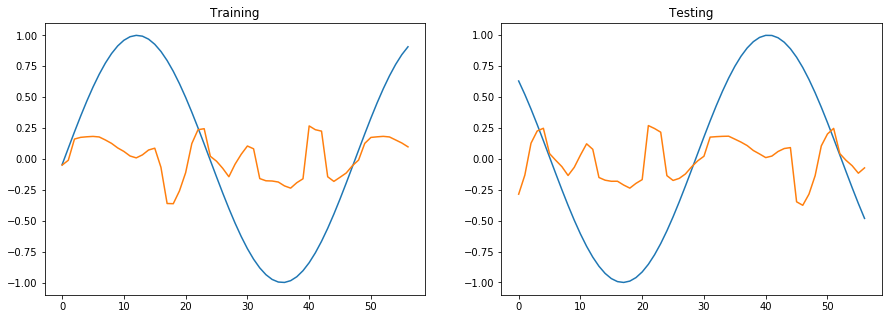

In [43]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

y_pred_train = model(X_train[0]).detach().numpy()
axis[0].plot(y_train[0], label='sin of actual angle')
axis[0].plot(y_pred_train, label='prediction')
axis[0].set_title(f"Training")

y_pred_test = model(X_test[0]).detach().numpy()
axis[1].plot(y_test[0], label='sin of actual angle')
axis[1].plot(y_pred_test, label='prediction')
axis[1].set_title(f"Testing")

# Combine all the operations and display
plt.show()
print()

In [38]:
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 100),
    torch.nn.Linear(100,1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for e in range(1000):
    avg_loss = 0
    for i in range(len(X_train)):
        # Get inputs
        y = y_train[i]
        x = X_train[i]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
#         if e % 10 == 9:
#             print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
#             avg_loss = 0

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
    avg_loss = 0

epoch 0; loss 29.951677322387695, avg loss 2932.9489612579346
epoch 1; loss 29.75255012512207, avg loss 2909.2476501464844
epoch 2; loss 29.702919006347656, avg loss 2907.654291152954
epoch 3; loss 29.683507919311523, avg loss 2907.1539268493652
epoch 4; loss 29.672344207763672, avg loss 2906.928207397461
epoch 5; loss 29.66377830505371, avg loss 2906.781276702881
epoch 6; loss 29.656208038330078, avg loss 2906.657928466797
epoch 7; loss 29.64906120300293, avg loss 2906.5406074523926
epoch 8; loss 29.642194747924805, avg loss 2906.424982070923
epoch 9; loss 29.63549041748047, avg loss 2906.309413909912
epoch 10; loss 29.628881454467773, avg loss 2906.197898864746
epoch 11; loss 29.622299194335938, avg loss 2906.0860557556152
epoch 12; loss 29.615680694580078, avg loss 2905.9783573150635
epoch 13; loss 29.60906219482422, avg loss 2905.8706645965576
epoch 14; loss 29.602426528930664, avg loss 2905.764389038086
epoch 15; loss 29.595693588256836, avg loss 2905.6535778045654
epoch 16; loss 

epoch 132; loss 29.179716110229492, avg loss 2895.5045890808105
epoch 133; loss 29.175878524780273, avg loss 2895.457036972046
epoch 134; loss 29.17392921447754, avg loss 2895.3895015716553
epoch 135; loss 29.171327590942383, avg loss 2895.3525829315186
epoch 136; loss 29.168636322021484, avg loss 2895.2848262786865
epoch 137; loss 29.16778564453125, avg loss 2895.2500762939453
epoch 138; loss 29.167463302612305, avg loss 2895.1749591827393
epoch 139; loss 29.16357421875, avg loss 2895.1407508850098
epoch 140; loss 29.165245056152344, avg loss 2895.075548171997
epoch 141; loss 29.16071128845215, avg loss 2895.031894683838
epoch 142; loss 29.161651611328125, avg loss 2894.9820823669434
epoch 143; loss 29.157546997070312, avg loss 2894.9391174316406
epoch 144; loss 29.157957077026367, avg loss 2894.8905239105225
epoch 145; loss 29.154632568359375, avg loss 2894.8581981658936
epoch 146; loss 29.153934478759766, avg loss 2894.805932998657
epoch 147; loss 29.151479721069336, avg loss 2894.7

epoch 263; loss 28.90433120727539, avg loss 2890.3980464935303
epoch 264; loss 28.90092658996582, avg loss 2890.4124069213867
epoch 265; loss 28.90191650390625, avg loss 2890.3707427978516
epoch 266; loss 28.897228240966797, avg loss 2890.2968883514404
epoch 267; loss 28.89676856994629, avg loss 2890.3450050354004
epoch 268; loss 28.891748428344727, avg loss 2890.3013973236084
epoch 269; loss 28.88934326171875, avg loss 2890.295639038086
epoch 270; loss 28.890399932861328, avg loss 2890.207414627075
epoch 271; loss 28.888954162597656, avg loss 2890.235887527466
epoch 272; loss 28.88414764404297, avg loss 2890.1749515533447
epoch 273; loss 28.883386611938477, avg loss 2890.1584796905518
epoch 274; loss 28.8844051361084, avg loss 2890.112386703491
epoch 275; loss 28.878158569335938, avg loss 2890.159055709839
epoch 276; loss 28.87885856628418, avg loss 2890.096216201782
epoch 277; loss 28.876789093017578, avg loss 2890.0396308898926
epoch 278; loss 28.874170303344727, avg loss 2890.04759

epoch 395; loss 28.730873107910156, avg loss 2888.1511154174805
epoch 396; loss 28.73020362854004, avg loss 2888.192695617676
epoch 397; loss 28.72736167907715, avg loss 2888.181146621704
epoch 398; loss 28.727235794067383, avg loss 2888.1608333587646
epoch 399; loss 28.728002548217773, avg loss 2888.092176437378
epoch 400; loss 28.72707176208496, avg loss 2888.135202407837
epoch 401; loss 28.725860595703125, avg loss 2888.1428050994873
epoch 402; loss 28.7230224609375, avg loss 2888.1432876586914
epoch 403; loss 28.723665237426758, avg loss 2888.0999870300293
epoch 404; loss 28.722578048706055, avg loss 2888.073667526245
epoch 405; loss 28.721416473388672, avg loss 2888.065553665161
epoch 406; loss 28.71966552734375, avg loss 2888.0713272094727
epoch 407; loss 28.718408584594727, avg loss 2888.0698833465576
epoch 408; loss 28.717029571533203, avg loss 2888.0362606048584
epoch 409; loss 28.716169357299805, avg loss 2888.0607624053955
epoch 410; loss 28.713594436645508, avg loss 2888.01

epoch 525; loss 28.602157592773438, avg loss 2886.870403289795
epoch 526; loss 28.60106086730957, avg loss 2887.0498428344727
epoch 527; loss 28.600975036621094, avg loss 2886.933904647827
epoch 528; loss 28.599279403686523, avg loss 2886.9765796661377
epoch 529; loss 28.59914207458496, avg loss 2886.9085731506348
epoch 530; loss 28.59857749938965, avg loss 2886.8695640563965
epoch 531; loss 28.599884033203125, avg loss 2886.9206523895264
epoch 532; loss 28.599002838134766, avg loss 2886.9220447540283
epoch 533; loss 28.597597122192383, avg loss 2886.924793243408
epoch 534; loss 28.596818923950195, avg loss 2886.9527912139893
epoch 535; loss 28.596954345703125, avg loss 2886.8711738586426
epoch 536; loss 28.596141815185547, avg loss 2886.8547229766846
epoch 537; loss 28.596424102783203, avg loss 2886.870418548584
epoch 538; loss 28.596027374267578, avg loss 2886.8899784088135
epoch 539; loss 28.595653533935547, avg loss 2886.8652114868164
epoch 540; loss 28.595956802368164, avg loss 28

epoch 655; loss 28.56647300720215, avg loss 2886.481367111206
epoch 656; loss 28.565181732177734, avg loss 2886.565362930298
epoch 657; loss 28.56395721435547, avg loss 2886.5018463134766
epoch 658; loss 28.56650733947754, avg loss 2886.4216136932373
epoch 659; loss 28.565570831298828, avg loss 2886.426803588867
epoch 660; loss 28.564727783203125, avg loss 2886.5296688079834
epoch 661; loss 28.565292358398438, avg loss 2886.44877243042
epoch 662; loss 28.567588806152344, avg loss 2886.5195713043213
epoch 663; loss 28.563411712646484, avg loss 2886.489589691162
epoch 664; loss 28.565603256225586, avg loss 2886.4620819091797
epoch 665; loss 28.566932678222656, avg loss 2886.554313659668
epoch 666; loss 28.562929153442383, avg loss 2886.494073867798
epoch 667; loss 28.564144134521484, avg loss 2886.528726577759
epoch 668; loss 28.564115524291992, avg loss 2886.387451171875
epoch 669; loss 28.566261291503906, avg loss 2886.473554611206
epoch 670; loss 28.565919876098633, avg loss 2886.5683

epoch 787; loss 28.54889488220215, avg loss 2886.323818206787
epoch 788; loss 28.5459041595459, avg loss 2886.2932167053223
epoch 789; loss 28.548080444335938, avg loss 2886.3051834106445
epoch 790; loss 28.547292709350586, avg loss 2886.2618408203125
epoch 791; loss 28.548696517944336, avg loss 2886.283401489258
epoch 792; loss 28.54791831970215, avg loss 2886.350317001343
epoch 793; loss 28.547454833984375, avg loss 2886.254186630249
epoch 794; loss 28.54717445373535, avg loss 2886.271827697754
epoch 795; loss 28.54817771911621, avg loss 2886.2469177246094
epoch 796; loss 28.549312591552734, avg loss 2886.3199138641357
epoch 797; loss 28.547767639160156, avg loss 2886.246162414551
epoch 798; loss 28.55022430419922, avg loss 2886.293785095215
epoch 799; loss 28.550539016723633, avg loss 2886.3553504943848
epoch 800; loss 28.54702377319336, avg loss 2886.2519874572754
epoch 801; loss 28.548688888549805, avg loss 2886.2666721343994
epoch 802; loss 28.54949951171875, avg loss 2886.311750

epoch 919; loss 28.544326782226562, avg loss 2886.061408996582
epoch 920; loss 28.544387817382812, avg loss 2886.0958576202393
epoch 921; loss 28.545677185058594, avg loss 2886.150815963745
epoch 922; loss 28.54404640197754, avg loss 2886.1591205596924
epoch 923; loss 28.544355392456055, avg loss 2886.087345123291
epoch 924; loss 28.544082641601562, avg loss 2886.1258544921875
epoch 925; loss 28.54425811767578, avg loss 2886.1315956115723
epoch 926; loss 28.547012329101562, avg loss 2886.2305488586426
epoch 927; loss 28.543174743652344, avg loss 2886.100561141968
epoch 928; loss 28.544963836669922, avg loss 2886.126756668091
epoch 929; loss 28.543668746948242, avg loss 2886.139102935791
epoch 930; loss 28.546016693115234, avg loss 2886.1140670776367
epoch 931; loss 28.545988082885742, avg loss 2886.1911277770996
epoch 932; loss 28.544647216796875, avg loss 2886.091714859009
epoch 933; loss 28.544157028198242, avg loss 2886.127321243286
epoch 934; loss 28.544614791870117, avg loss 2886.

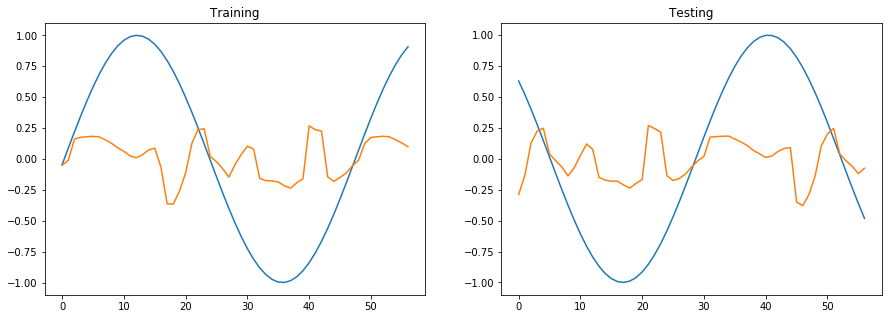

In [40]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

y_pred_train = model(X_train[0]).detach().numpy()
axis[0].plot(y_train[0], label='sin of actual angle')
axis[0].plot(y_pred_train, label='prediction')
axis[0].set_title(f"Training")

y_pred_test = model(X_test[0]).detach().numpy()
axis[1].plot(y_test[0], label='sin of actual angle')
axis[1].plot(y_pred_test, label='prediction')
axis[1].set_title(f"Testing")

# Combine all the operations and display
plt.show()
print()

In [46]:
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 2),
    nn.Tanh(),
    torch.nn.Linear(2, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
# loss_fn = torch.nn.L1Loss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for e in range(1000):
    avg_loss = 0
    for i in range(len(X_train)):
        # Get inputs
        y = y_train[i]
        x = X_train[i]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
#         if e % 10 == 9:
#             print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
#             avg_loss = 0

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    print(f"epoch {e}; loss {loss.item()}, avg loss {avg_loss}")
    avg_loss = 0

epoch 0; loss 28.705533981323242, avg loss 3055.655698776245
epoch 1; loss 26.788105010986328, avg loss 2807.583787918091
epoch 2; loss 25.520103454589844, avg loss 2687.830484390259
epoch 3; loss 24.339996337890625, avg loss 2587.6187286376953
epoch 4; loss 23.102252960205078, avg loss 2486.5121173858643
epoch 5; loss 21.785024642944336, avg loss 2377.5083713531494
epoch 6; loss 20.417356491088867, avg loss 2260.9734592437744
epoch 7; loss 19.045795440673828, avg loss 2140.1856689453125
epoch 8; loss 17.717506408691406, avg loss 2019.1971473693848
epoch 9; loss 16.47323989868164, avg loss 1901.992437362671
epoch 10; loss 15.344375610351562, avg loss 1792.0821180343628
epoch 11; loss 14.351414680480957, avg loss 1692.2431716918945
epoch 12; loss 13.503568649291992, avg loss 1604.3665103912354
epoch 13; loss 12.799436569213867, avg loss 1529.4103832244873
epoch 14; loss 12.228787422180176, avg loss 1467.4373216629028
epoch 15; loss 11.775270462036133, avg loss 1417.7160596847534
epoch 1

epoch 131; loss 10.030393600463867, avg loss 1254.9417877197266
epoch 132; loss 10.030384063720703, avg loss 1254.9082717895508
epoch 133; loss 10.030372619628906, avg loss 1254.8745565414429
epoch 134; loss 10.030362129211426, avg loss 1254.840693473816
epoch 135; loss 10.03035831451416, avg loss 1254.806619644165
epoch 136; loss 10.030349731445312, avg loss 1254.7724018096924
epoch 137; loss 10.030338287353516, avg loss 1254.7380237579346
epoch 138; loss 10.030327796936035, avg loss 1254.7034177780151
epoch 139; loss 10.030320167541504, avg loss 1254.668667793274
epoch 140; loss 10.03031063079834, avg loss 1254.6337594985962
epoch 141; loss 10.030302047729492, avg loss 1254.5986289978027
epoch 142; loss 10.030292510986328, avg loss 1254.5633544921875
epoch 143; loss 10.030282020568848, avg loss 1254.5278568267822
epoch 144; loss 10.030275344848633, avg loss 1254.4921798706055
epoch 145; loss 10.03026294708252, avg loss 1254.4563398361206
epoch 146; loss 10.030250549316406, avg loss 1

epoch 261; loss 10.022660255432129, avg loss 1248.645450592041
epoch 262; loss 10.022520065307617, avg loss 1248.5782442092896
epoch 263; loss 10.022380828857422, avg loss 1248.510705947876
epoch 264; loss 10.02224063873291, avg loss 1248.4428806304932
epoch 265; loss 10.0220947265625, avg loss 1248.3746891021729
epoch 266; loss 10.021952629089355, avg loss 1248.3062086105347
epoch 267; loss 10.021804809570312, avg loss 1248.237392425537
epoch 268; loss 10.021659851074219, avg loss 1248.1682138442993
epoch 269; loss 10.021506309509277, avg loss 1248.098768234253
epoch 270; loss 10.021357536315918, avg loss 1248.02898311615
epoch 271; loss 10.02120590209961, avg loss 1247.9589042663574
epoch 272; loss 10.021053314208984, avg loss 1247.88844871521
epoch 273; loss 10.020895004272461, avg loss 1247.8176727294922
epoch 274; loss 10.020736694335938, avg loss 1247.7466049194336
epoch 275; loss 10.020578384399414, avg loss 1247.6751976013184
epoch 276; loss 10.020417213439941, avg loss 1247.60

epoch 392; loss 9.98977279663086, avg loss 1237.6613931655884
epoch 393; loss 9.989401817321777, avg loss 1237.5699739456177
epoch 394; loss 9.989030838012695, avg loss 1237.4786853790283
epoch 395; loss 9.988651275634766, avg loss 1237.3873825073242
epoch 396; loss 9.988272666931152, avg loss 1237.2962017059326
epoch 397; loss 9.987896919250488, avg loss 1237.2051401138306
epoch 398; loss 9.987520217895508, avg loss 1237.1142120361328
epoch 399; loss 9.987133979797363, avg loss 1237.0233421325684
epoch 400; loss 9.986749649047852, avg loss 1236.9326009750366
epoch 401; loss 9.98636245727539, avg loss 1236.8420133590698
epoch 402; loss 9.98597526550293, avg loss 1236.7514953613281
epoch 403; loss 9.98558521270752, avg loss 1236.661150932312
epoch 404; loss 9.985196113586426, avg loss 1236.5709018707275
epoch 405; loss 9.984804153442383, avg loss 1236.480848312378
epoch 406; loss 9.98440933227539, avg loss 1236.3909091949463
epoch 407; loss 9.984015464782715, avg loss 1236.301097869873


epoch 524; loss 9.932395935058594, avg loss 1227.6466512680054
epoch 525; loss 9.931955337524414, avg loss 1227.5918645858765
epoch 526; loss 9.931514739990234, avg loss 1227.5373239517212
epoch 527; loss 9.931073188781738, avg loss 1227.483154296875
epoch 528; loss 9.93064022064209, avg loss 1227.42928981781
epoch 529; loss 9.93020248413086, avg loss 1227.3757581710815
epoch 530; loss 9.929768562316895, avg loss 1227.322525024414
epoch 531; loss 9.929332733154297, avg loss 1227.2696495056152
epoch 532; loss 9.928898811340332, avg loss 1227.2170877456665
epoch 533; loss 9.92846393585205, avg loss 1227.164810180664
epoch 534; loss 9.928032875061035, avg loss 1227.1128616333008
epoch 535; loss 9.927602767944336, avg loss 1227.0611963272095
epoch 536; loss 9.92717170715332, avg loss 1227.0099020004272
epoch 537; loss 9.926739692687988, avg loss 1226.958896636963
epoch 538; loss 9.926311492919922, avg loss 1226.908224105835
epoch 539; loss 9.925884246826172, avg loss 1226.8578424453735
epo

epoch 657; loss 9.883434295654297, avg loss 1222.6874055862427
epoch 658; loss 9.883151054382324, avg loss 1222.6637649536133
epoch 659; loss 9.88286304473877, avg loss 1222.6402921676636
epoch 660; loss 9.882580757141113, avg loss 1222.6169157028198
epoch 661; loss 9.882296562194824, avg loss 1222.5937128067017
epoch 662; loss 9.882012367248535, avg loss 1222.5706272125244
epoch 663; loss 9.881731033325195, avg loss 1222.547698020935
epoch 664; loss 9.881452560424805, avg loss 1222.524938583374
epoch 665; loss 9.88117504119873, avg loss 1222.5022792816162
epoch 666; loss 9.88089370727539, avg loss 1222.4797887802124
epoch 667; loss 9.880620002746582, avg loss 1222.4573984146118
epoch 668; loss 9.88034439086914, avg loss 1222.4351377487183
epoch 669; loss 9.880071640014648, avg loss 1222.4130506515503
epoch 670; loss 9.879796028137207, avg loss 1222.3910808563232
epoch 671; loss 9.879526138305664, avg loss 1222.3692302703857
epoch 672; loss 9.879256248474121, avg loss 1222.347507476806

epoch 788; loss 9.85467529296875, avg loss 1220.4990196228027
epoch 789; loss 9.854512214660645, avg loss 1220.4873323440552
epoch 790; loss 9.854351997375488, avg loss 1220.4756164550781
epoch 791; loss 9.854193687438965, avg loss 1220.4640378952026
epoch 792; loss 9.854031562805176, avg loss 1220.4524393081665
epoch 793; loss 9.853873252868652, avg loss 1220.4409112930298
epoch 794; loss 9.853716850280762, avg loss 1220.4294261932373
epoch 795; loss 9.853560447692871, avg loss 1220.418041229248
epoch 796; loss 9.853402137756348, avg loss 1220.4066257476807
epoch 797; loss 9.853246688842773, avg loss 1220.3953046798706
epoch 798; loss 9.853089332580566, avg loss 1220.3840322494507
epoch 799; loss 9.852935791015625, avg loss 1220.372797012329
epoch 800; loss 9.852783203125, avg loss 1220.3616247177124
epoch 801; loss 9.852627754211426, avg loss 1220.3504638671875
epoch 802; loss 9.852476119995117, avg loss 1220.3393545150757
epoch 803; loss 9.852325439453125, avg loss 1220.328310966491

epoch 919; loss 9.83861255645752, avg loss 1219.2788314819336
epoch 920; loss 9.838522911071777, avg loss 1219.2712669372559
epoch 921; loss 9.838434219360352, avg loss 1219.2637186050415
epoch 922; loss 9.83834457397461, avg loss 1219.2561674118042
epoch 923; loss 9.838258743286133, avg loss 1219.2486658096313
epoch 924; loss 9.83816909790039, avg loss 1219.2411661148071
epoch 925; loss 9.838080406188965, avg loss 1219.2336893081665
epoch 926; loss 9.837992668151855, avg loss 1219.22620677948
epoch 927; loss 9.837903022766113, avg loss 1219.218768119812
epoch 928; loss 9.837817192077637, avg loss 1219.2113466262817
epoch 929; loss 9.837728500366211, avg loss 1219.2039623260498
epoch 930; loss 9.837646484375, avg loss 1219.1965675354004
epoch 931; loss 9.83755874633789, avg loss 1219.189190864563
epoch 932; loss 9.83747386932373, avg loss 1219.181833267212
epoch 933; loss 9.837385177612305, avg loss 1219.1744956970215
epoch 934; loss 9.837305068969727, avg loss 1219.1671600341797
epoch

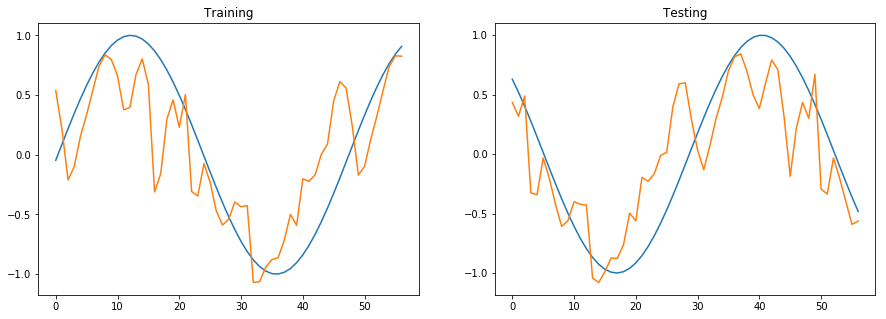

In [47]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

y_pred_train = model(X_train[0]).detach().numpy()
axis[0].plot(y_train[0], label='sin of actual angle')
axis[0].plot(y_pred_train, label='prediction')
axis[0].set_title(f"Training")

y_pred_test = model(X_test[0]).detach().numpy()
axis[1].plot(y_test[0], label='sin of actual angle')
axis[1].plot(y_pred_test, label='prediction')
axis[1].set_title(f"Testing")

# Combine all the operations and display
plt.show()
print()

## Variable Velocity

## Not Working Models

In [97]:
import torch
import math


# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

for epoch in range(1000):
    
    for i in range(len(X_train)):
      # Get inputs
        x = X_train[i]
#         y_pred = y_train[i].view(57,-1)
        y = y_train[i]
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        if i % 100 == 99:
            print(f"epoch {epoch}; iter {i}; loss {loss.item()}")

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()


linear_layer = model[0]
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} var1 + {linear_layer.weight[:, 1].item()} var2')

epoch 0; iter 99; loss 30.913440704345703
epoch 1; iter 99; loss 29.133665084838867
epoch 2; iter 99; loss 28.217041015625
epoch 3; iter 99; loss 27.734615325927734
epoch 4; iter 99; loss 27.492202758789062
epoch 5; iter 99; loss 27.38090705871582
epoch 6; iter 99; loss 27.3315486907959
epoch 7; iter 99; loss 27.306316375732422
epoch 8; iter 99; loss 27.291065216064453
epoch 9; iter 99; loss 27.281509399414062
epoch 10; iter 99; loss 27.275699615478516
epoch 11; iter 99; loss 27.272279739379883
epoch 12; iter 99; loss 27.270301818847656
epoch 13; iter 99; loss 27.269163131713867
epoch 14; iter 99; loss 27.268516540527344
epoch 15; iter 99; loss 27.268146514892578
epoch 16; iter 99; loss 27.26793098449707
epoch 17; iter 99; loss 27.267807006835938
epoch 18; iter 99; loss 27.26774024963379
epoch 19; iter 99; loss 27.267698287963867
epoch 20; iter 99; loss 27.26767921447754
epoch 21; iter 99; loss 27.267663955688477
epoch 22; iter 99; loss 27.267654418945312
epoch 23; iter 99; loss 27.267

epoch 194; iter 99; loss 27.267642974853516
epoch 195; iter 99; loss 27.267642974853516
epoch 196; iter 99; loss 27.267642974853516
epoch 197; iter 99; loss 27.267642974853516
epoch 198; iter 99; loss 27.267642974853516
epoch 199; iter 99; loss 27.267642974853516
epoch 200; iter 99; loss 27.267642974853516
epoch 201; iter 99; loss 27.267642974853516
epoch 202; iter 99; loss 27.267642974853516
epoch 203; iter 99; loss 27.267642974853516
epoch 204; iter 99; loss 27.267642974853516
epoch 205; iter 99; loss 27.267642974853516
epoch 206; iter 99; loss 27.267642974853516
epoch 207; iter 99; loss 27.267642974853516
epoch 208; iter 99; loss 27.267642974853516
epoch 209; iter 99; loss 27.267642974853516
epoch 210; iter 99; loss 27.267642974853516
epoch 211; iter 99; loss 27.267642974853516
epoch 212; iter 99; loss 27.267642974853516
epoch 213; iter 99; loss 27.267642974853516
epoch 214; iter 99; loss 27.267642974853516
epoch 215; iter 99; loss 27.267642974853516
epoch 216; iter 99; loss 27.2676

epoch 386; iter 99; loss 27.267642974853516
epoch 387; iter 99; loss 27.267642974853516
epoch 388; iter 99; loss 27.267642974853516
epoch 389; iter 99; loss 27.267642974853516
epoch 390; iter 99; loss 27.267642974853516
epoch 391; iter 99; loss 27.267642974853516
epoch 392; iter 99; loss 27.267642974853516
epoch 393; iter 99; loss 27.267642974853516
epoch 394; iter 99; loss 27.267642974853516
epoch 395; iter 99; loss 27.267642974853516
epoch 396; iter 99; loss 27.267642974853516
epoch 397; iter 99; loss 27.267642974853516
epoch 398; iter 99; loss 27.267642974853516
epoch 399; iter 99; loss 27.267642974853516
epoch 400; iter 99; loss 27.267642974853516
epoch 401; iter 99; loss 27.267642974853516
epoch 402; iter 99; loss 27.267642974853516
epoch 403; iter 99; loss 27.267642974853516
epoch 404; iter 99; loss 27.267642974853516
epoch 405; iter 99; loss 27.267642974853516
epoch 406; iter 99; loss 27.267642974853516
epoch 407; iter 99; loss 27.267642974853516
epoch 408; iter 99; loss 27.2676

epoch 575; iter 99; loss 27.267642974853516
epoch 576; iter 99; loss 27.267642974853516
epoch 577; iter 99; loss 27.267642974853516
epoch 578; iter 99; loss 27.267642974853516
epoch 579; iter 99; loss 27.267642974853516
epoch 580; iter 99; loss 27.267642974853516
epoch 581; iter 99; loss 27.267642974853516
epoch 582; iter 99; loss 27.267642974853516
epoch 583; iter 99; loss 27.267642974853516
epoch 584; iter 99; loss 27.267642974853516
epoch 585; iter 99; loss 27.267642974853516
epoch 586; iter 99; loss 27.267642974853516
epoch 587; iter 99; loss 27.267642974853516
epoch 588; iter 99; loss 27.267642974853516
epoch 589; iter 99; loss 27.267642974853516
epoch 590; iter 99; loss 27.267642974853516
epoch 591; iter 99; loss 27.267642974853516
epoch 592; iter 99; loss 27.267642974853516
epoch 593; iter 99; loss 27.267642974853516
epoch 594; iter 99; loss 27.267642974853516
epoch 595; iter 99; loss 27.267642974853516
epoch 596; iter 99; loss 27.267642974853516
epoch 597; iter 99; loss 27.2676

epoch 762; iter 99; loss 27.267642974853516
epoch 763; iter 99; loss 27.267642974853516
epoch 764; iter 99; loss 27.267642974853516
epoch 765; iter 99; loss 27.267642974853516
epoch 766; iter 99; loss 27.267642974853516
epoch 767; iter 99; loss 27.267642974853516
epoch 768; iter 99; loss 27.267642974853516
epoch 769; iter 99; loss 27.267642974853516
epoch 770; iter 99; loss 27.267642974853516
epoch 771; iter 99; loss 27.267642974853516
epoch 772; iter 99; loss 27.267642974853516
epoch 773; iter 99; loss 27.267642974853516
epoch 774; iter 99; loss 27.267642974853516
epoch 775; iter 99; loss 27.267642974853516
epoch 776; iter 99; loss 27.267642974853516
epoch 777; iter 99; loss 27.267642974853516
epoch 778; iter 99; loss 27.267642974853516
epoch 779; iter 99; loss 27.267642974853516
epoch 780; iter 99; loss 27.267642974853516
epoch 781; iter 99; loss 27.267642974853516
epoch 782; iter 99; loss 27.267642974853516
epoch 783; iter 99; loss 27.267642974853516
epoch 784; iter 99; loss 27.2676

epoch 953; iter 99; loss 27.267642974853516
epoch 954; iter 99; loss 27.267642974853516
epoch 955; iter 99; loss 27.267642974853516
epoch 956; iter 99; loss 27.267642974853516
epoch 957; iter 99; loss 27.267642974853516
epoch 958; iter 99; loss 27.267642974853516
epoch 959; iter 99; loss 27.267642974853516
epoch 960; iter 99; loss 27.267642974853516
epoch 961; iter 99; loss 27.267642974853516
epoch 962; iter 99; loss 27.267642974853516
epoch 963; iter 99; loss 27.267642974853516
epoch 964; iter 99; loss 27.267642974853516
epoch 965; iter 99; loss 27.267642974853516
epoch 966; iter 99; loss 27.267642974853516
epoch 967; iter 99; loss 27.267642974853516
epoch 968; iter 99; loss 27.267642974853516
epoch 969; iter 99; loss 27.267642974853516
epoch 970; iter 99; loss 27.267642974853516
epoch 971; iter 99; loss 27.267642974853516
epoch 972; iter 99; loss 27.267642974853516
epoch 973; iter 99; loss 27.267642974853516
epoch 974; iter 99; loss 27.267642974853516
epoch 975; iter 99; loss 27.2676

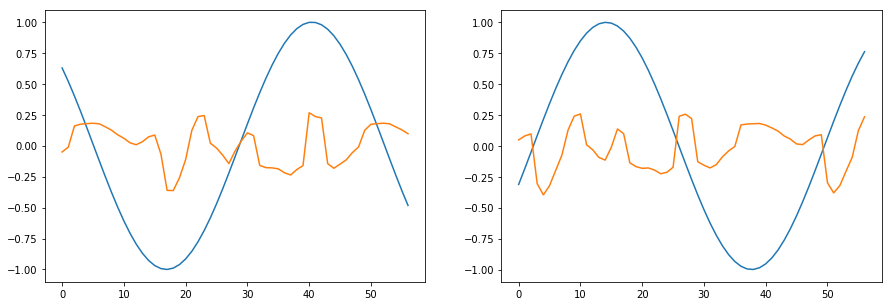

In [98]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))
  
axis[0].plot(y_test[0], label="sin()")
out1 = model(X_train[0]).detach().numpy()
# axis[0, 0].plot(X[0][:,0], label="var1")
# axis[0, 0].plot(X[0][:,1], label="var2")
axis[0].plot(out1, label="var1 + var2")
# axis[0].set_title(f"Dataset No. {train_ids[0]}")
out2 = model(X_train[1]).detach().numpy()
axis[1].plot(y_test[1], label="sin()")
# axis[0, 1].plot(X[1][:,0], label="var1")
# axis[0, 1].plot(X[1][:,1], label="var2")
axis[1].plot(out2, label="var1 + var2")
# axis[0].set_title(f"Dataset No. {train_ids[1]}")
  
# Combine all the operations and display
plt.show()

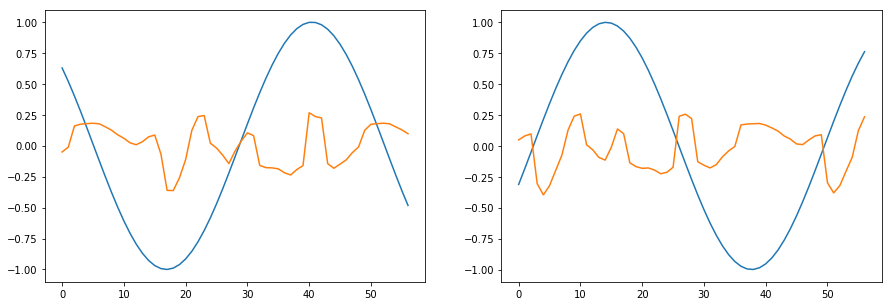

In [96]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(15, 5))
  
axis[0].plot(y_test[0], label="sin()")
out1 = model(X_train[0]).detach().numpy()
# axis[0, 0].plot(X[0][:,0], label="var1")
# axis[0, 0].plot(X[0][:,1], label="var2")
axis[0].plot(out1, label="var1 + var2")
# axis[0].set_title(f"Dataset No. {train_ids[0]}")
out2 = model(X_train[1]).detach().numpy()
axis[1].plot(y_test[1], label="sin()")
# axis[0, 1].plot(X[1][:,0], label="var1")
# axis[0, 1].plot(X[1][:,1], label="var2")
axis[1].plot(out2, label="var1 + var2")
# axis[0].set_title(f"Dataset No. {train_ids[1]}")
  
# Combine all the operations and display
plt.show()

## 11/15 Efforts

In [9]:
class MLP_large(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

class MLP_medium(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

class MLP_small(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

class Net1(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

## SIN() function Approximation

In [52]:
# sin(pi*x)
def func1(x):
    return np.sin(x)

# sin(pi*x)
def func2(x):
    return np.sin(math.pi * x)

def func3(x):
    return 0.5*np.sin(0.5x)**2 * 3*np.cos(x)**3

SyntaxError: invalid syntax (<ipython-input-52-29ca7975d12a>, line 10)

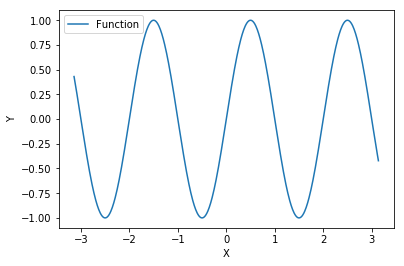

In [55]:
#Create dataset
data = torch.arange(-math.pi, math.pi, 0.01).unsqueeze(1) #Make data 200x1 instead of 200
target = func1(data)
# target = func2(data)
# target = func3(data)

#Plot dataset
plt.plot(data, target, label="Function")
# plt.plot(data, output.detach().numpy(), label="Prediction")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc="best")
plt.show()

In [56]:
#Hyperparames
learn_rate = 0.01

model = Net1()
# optimizer = torch.optim.Adam(mlp.parameters(), lr=learn_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)
loss_function = nn.L1Loss()



#Track average training loss
avg_loss = 0.0

#Training step
model.train() #Put model into training mode
for i in range(10000):
    if i % 1000 == 0:
        print(f"Iter: {i}")
    
    #Zero the gradients
    optimizer.zero_grad()
    
    #Forward pass and get loss
    output = model(data)
    loss = loss_function(output, target)
#     loss = nn.MSELoss()
    
    #Back propagation to compute gradients, optimizer step() to update weights
    loss.backward()
    optimizer.step()
    
    avg_loss += loss.item()
    #Print average loss
    if i % 1000 == 0:
        print(f"Avg Loss: {avg_loss}")
        avg_loss = 0

Iter: 0
Avg Loss: 0.6798236966133118
Iter: 1000
Avg Loss: 567.7276962399483
Iter: 2000
Avg Loss: 510.1350169181824
Iter: 3000
Avg Loss: 444.1916088461876
Iter: 4000
Avg Loss: 366.9856156408787
Iter: 5000
Avg Loss: 296.8468554019928
Iter: 6000
Avg Loss: 256.29036048054695
Iter: 7000
Avg Loss: 248.2015231847763
Iter: 8000
Avg Loss: 250.43738588690758
Iter: 9000
Avg Loss: 247.00706100463867


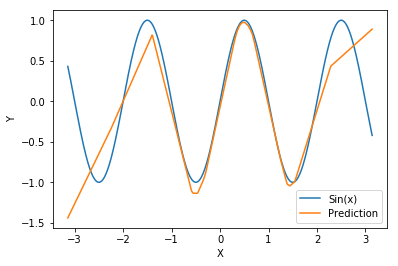

In [57]:
plt.plot(data, target, label="Function")
plt.plot(data, output.detach().numpy(), label="Prediction")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc="best")
plt.show()

## MAIN NETWORK: ANGLE PREDICTION

In [48]:
# TRAINING

# HYPERPARAMETERS
epochs = 500
learn_rate = 0.001

# Set fixed random number seed
torch.manual_seed(42)

# Initialize the MLP
mlp_small = MLP_small()
mlp_medium = MLP_medium()
mlp_large = MLP_large()

models = [mlp_small, mlp_medium, mlp_large]
epoch_schedule = [10, 100, 500]

# Define the loss function and optimizer
loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learn_rate)
# optimizer = torch.optim.SGD(mlp.parameters(), lr=learn_rate)

# Run the training loop
for epoch in range(0, epochs):

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i in range(len(X_train)):

      # Get inputs
#       inputs, targets = data
        inputs = X_train[i]
        targets = y_train[i].view(57,-1)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)
        
#         print("inputs:", inputs.shape)
#         print('targets:', targets.shape)
#         print("outputs:", outputs.shape)
        
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 9:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 10))
            current_loss = 0.0
        

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch    10: 57.424
Loss after mini-batch    20: 47.408
Loss after mini-batch    30: 43.331
Loss after mini-batch    40: 32.601
Loss after mini-batch    50: 50.308
Loss after mini-batch    60: 39.202
Loss after mini-batch    70: 47.884
Loss after mini-batch    80: 35.038
Loss after mini-batch    90: 30.135
Loss after mini-batch   100: 32.282
Starting epoch 2
Loss after mini-batch    10: 27.676
Loss after mini-batch    20: 21.387
Loss after mini-batch    30: 18.454
Loss after mini-batch    40: 12.629
Loss after mini-batch    50: 22.363
Loss after mini-batch    60: 16.346
Loss after mini-batch    70: 20.748
Loss after mini-batch    80: 14.482
Loss after mini-batch    90: 12.238
Loss after mini-batch   100: 12.918
Starting epoch 3
Loss after mini-batch    10: 11.746
Loss after mini-batch    20: 9.719
Loss after mini-batch    30: 8.122
Loss after mini-batch    40: 6.933
Loss after mini-batch    50: 10.721
Loss after mini-batch    60: 8.594
Loss after mini-b

Loss after mini-batch    40: 7.439
Loss after mini-batch    50: 8.167
Loss after mini-batch    60: 7.029
Loss after mini-batch    70: 8.287
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.740
Loss after mini-batch   100: 7.200
Starting epoch 24
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.741
Loss after mini-batch    30: 6.849
Loss after mini-batch    40: 7.439
Loss after mini-batch    50: 8.167
Loss after mini-batch    60: 7.029
Loss after mini-batch    70: 8.286
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.739
Loss after mini-batch   100: 7.200
Starting epoch 25
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.741
Loss after mini-batch    30: 6.850
Loss after mini-batch    40: 7.439
Loss after mini-batch    50: 8.168
Loss after mini-batch    60: 7.028
Loss after mini-batch    70: 8.286
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.739
Loss after mini-batch   100: 7.199
Starting epoch 26
L

Loss after mini-batch   100: 7.191
Starting epoch 47
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.734
Loss after mini-batch    30: 6.860
Loss after mini-batch    40: 7.441
Loss after mini-batch    50: 8.166
Loss after mini-batch    60: 7.017
Loss after mini-batch    70: 8.277
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.734
Loss after mini-batch   100: 7.191
Starting epoch 48
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.734
Loss after mini-batch    30: 6.861
Loss after mini-batch    40: 7.442
Loss after mini-batch    50: 8.165
Loss after mini-batch    60: 7.017
Loss after mini-batch    70: 8.277
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.734
Loss after mini-batch   100: 7.190
Starting epoch 49
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.733
Loss after mini-batch    30: 6.861
Loss after mini-batch    40: 7.442
Loss after mini-batch    50: 8.165
Loss after mini-batch    60: 7.016
L

Loss after mini-batch    70: 8.271
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.729
Loss after mini-batch   100: 7.185
Starting epoch 71
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.728
Loss after mini-batch    30: 6.869
Loss after mini-batch    40: 7.447
Loss after mini-batch    50: 8.158
Loss after mini-batch    60: 7.009
Loss after mini-batch    70: 8.270
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.729
Loss after mini-batch   100: 7.184
Starting epoch 72
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.728
Loss after mini-batch    30: 6.869
Loss after mini-batch    40: 7.448
Loss after mini-batch    50: 8.157
Loss after mini-batch    60: 7.008
Loss after mini-batch    70: 8.270
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.729
Loss after mini-batch   100: 7.184
Starting epoch 73
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.728
Loss after mini-batch    30: 6.870
L

Loss after mini-batch    70: 8.265
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.725
Loss after mini-batch   100: 7.180
Starting epoch 94
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.724
Loss after mini-batch    30: 6.877
Loss after mini-batch    40: 7.452
Loss after mini-batch    50: 8.151
Loss after mini-batch    60: 7.002
Loss after mini-batch    70: 8.265
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.725
Loss after mini-batch   100: 7.180
Starting epoch 95
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.724
Loss after mini-batch    30: 6.877
Loss after mini-batch    40: 7.453
Loss after mini-batch    50: 8.150
Loss after mini-batch    60: 7.002
Loss after mini-batch    70: 8.264
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.725
Loss after mini-batch   100: 7.180
Starting epoch 96
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.724
Loss after mini-batch    30: 6.878
L

Loss after mini-batch    20: 7.720
Loss after mini-batch    30: 6.885
Loss after mini-batch    40: 7.457
Loss after mini-batch    50: 8.144
Loss after mini-batch    60: 6.996
Loss after mini-batch    70: 8.260
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.722
Loss after mini-batch   100: 7.176
Starting epoch 119
Loss after mini-batch    10: 8.142
Loss after mini-batch    20: 7.720
Loss after mini-batch    30: 6.885
Loss after mini-batch    40: 7.457
Loss after mini-batch    50: 8.144
Loss after mini-batch    60: 6.996
Loss after mini-batch    70: 8.259
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.722
Loss after mini-batch   100: 7.176
Starting epoch 120
Loss after mini-batch    10: 8.142
Loss after mini-batch    20: 7.720
Loss after mini-batch    30: 6.886
Loss after mini-batch    40: 7.457
Loss after mini-batch    50: 8.144
Loss after mini-batch    60: 6.996
Loss after mini-batch    70: 8.259
Loss after mini-batch    80: 8.352
Loss after mini-b

Loss after mini-batch    30: 6.892
Loss after mini-batch    40: 7.461
Loss after mini-batch    50: 8.138
Loss after mini-batch    60: 6.992
Loss after mini-batch    70: 8.255
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.720
Loss after mini-batch   100: 7.173
Starting epoch 143
Loss after mini-batch    10: 8.144
Loss after mini-batch    20: 7.716
Loss after mini-batch    30: 6.893
Loss after mini-batch    40: 7.461
Loss after mini-batch    50: 8.138
Loss after mini-batch    60: 6.992
Loss after mini-batch    70: 8.255
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.720
Loss after mini-batch   100: 7.173
Starting epoch 144
Loss after mini-batch    10: 8.144
Loss after mini-batch    20: 7.716
Loss after mini-batch    30: 6.893
Loss after mini-batch    40: 7.461
Loss after mini-batch    50: 8.138
Loss after mini-batch    60: 6.991
Loss after mini-batch    70: 8.255
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.720
Loss after mini-b

Loss after mini-batch    90: 7.718
Loss after mini-batch   100: 7.171
Starting epoch 167
Loss after mini-batch    10: 8.146
Loss after mini-batch    20: 7.714
Loss after mini-batch    30: 6.899
Loss after mini-batch    40: 7.464
Loss after mini-batch    50: 8.133
Loss after mini-batch    60: 6.988
Loss after mini-batch    70: 8.251
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.718
Loss after mini-batch   100: 7.171
Starting epoch 168
Loss after mini-batch    10: 8.146
Loss after mini-batch    20: 7.713
Loss after mini-batch    30: 6.899
Loss after mini-batch    40: 7.464
Loss after mini-batch    50: 8.133
Loss after mini-batch    60: 6.988
Loss after mini-batch    70: 8.251
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.718
Loss after mini-batch   100: 7.171
Starting epoch 169
Loss after mini-batch    10: 8.146
Loss after mini-batch    20: 7.713
Loss after mini-batch    30: 6.899
Loss after mini-batch    40: 7.465
Loss after mini-batch    50: 8.13

Loss after mini-batch    10: 8.147
Loss after mini-batch    20: 7.711
Loss after mini-batch    30: 6.904
Loss after mini-batch    40: 7.467
Loss after mini-batch    50: 8.129
Loss after mini-batch    60: 6.985
Loss after mini-batch    70: 8.249
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.717
Loss after mini-batch   100: 7.169
Starting epoch 192
Loss after mini-batch    10: 8.147
Loss after mini-batch    20: 7.711
Loss after mini-batch    30: 6.904
Loss after mini-batch    40: 7.468
Loss after mini-batch    50: 8.128
Loss after mini-batch    60: 6.985
Loss after mini-batch    70: 8.249
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.717
Loss after mini-batch   100: 7.169
Starting epoch 193
Loss after mini-batch    10: 8.147
Loss after mini-batch    20: 7.711
Loss after mini-batch    30: 6.904
Loss after mini-batch    40: 7.468
Loss after mini-batch    50: 8.128
Loss after mini-batch    60: 6.985
Loss after mini-batch    70: 8.248
Loss after mini-b

Loss after mini-batch    50: 8.125
Loss after mini-batch    60: 6.983
Loss after mini-batch    70: 8.247
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.715
Loss after mini-batch   100: 7.168
Starting epoch 216
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.710
Loss after mini-batch    30: 6.907
Loss after mini-batch    40: 7.470
Loss after mini-batch    50: 8.125
Loss after mini-batch    60: 6.983
Loss after mini-batch    70: 8.247
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.715
Loss after mini-batch   100: 7.168
Starting epoch 217
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.710
Loss after mini-batch    30: 6.907
Loss after mini-batch    40: 7.470
Loss after mini-batch    50: 8.124
Loss after mini-batch    60: 6.983
Loss after mini-batch    70: 8.246
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.715
Loss after mini-batch   100: 7.168
Starting epoch 218
Loss after mini-batch    10: 8.14

Loss after mini-batch    30: 6.909
Loss after mini-batch    40: 7.472
Loss after mini-batch    50: 8.121
Loss after mini-batch    60: 6.982
Loss after mini-batch    70: 8.245
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.714
Loss after mini-batch   100: 7.168
Starting epoch 240
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.709
Loss after mini-batch    30: 6.910
Loss after mini-batch    40: 7.473
Loss after mini-batch    50: 8.121
Loss after mini-batch    60: 6.982
Loss after mini-batch    70: 8.245
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.714
Loss after mini-batch   100: 7.168
Starting epoch 241
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.709
Loss after mini-batch    30: 6.910
Loss after mini-batch    40: 7.473
Loss after mini-batch    50: 8.121
Loss after mini-batch    60: 6.982
Loss after mini-batch    70: 8.245
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.713
Loss after mini-b

Loss after mini-batch   100: 7.167
Starting epoch 263
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.709
Loss after mini-batch    30: 6.911
Loss after mini-batch    40: 7.475
Loss after mini-batch    50: 8.118
Loss after mini-batch    60: 6.981
Loss after mini-batch    70: 8.244
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.712
Loss after mini-batch   100: 7.167
Starting epoch 264
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.911
Loss after mini-batch    40: 7.475
Loss after mini-batch    50: 8.117
Loss after mini-batch    60: 6.981
Loss after mini-batch    70: 8.244
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.712
Loss after mini-batch   100: 7.167
Starting epoch 265
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.911
Loss after mini-batch    40: 7.475
Loss after mini-batch    50: 8.117
Loss after mini-batch    60: 6.98

Loss after mini-batch    90: 7.711
Loss after mini-batch   100: 7.166
Starting epoch 286
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.477
Loss after mini-batch    50: 8.114
Loss after mini-batch    60: 6.980
Loss after mini-batch    70: 8.243
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.711
Loss after mini-batch   100: 7.166
Starting epoch 287
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.477
Loss after mini-batch    50: 8.114
Loss after mini-batch    60: 6.980
Loss after mini-batch    70: 8.243
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.711
Loss after mini-batch   100: 7.166
Starting epoch 288
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.477
Loss after mini-batch    50: 8.11

Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.710
Loss after mini-batch   100: 7.166
Starting epoch 310
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.479
Loss after mini-batch    50: 8.111
Loss after mini-batch    60: 6.979
Loss after mini-batch    70: 8.242
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.709
Loss after mini-batch   100: 7.166
Starting epoch 311
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.479
Loss after mini-batch    50: 8.111
Loss after mini-batch    60: 6.979
Loss after mini-batch    70: 8.242
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.709
Loss after mini-batch   100: 7.166
Starting epoch 312
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.47

Loss after mini-batch    90: 7.708
Loss after mini-batch   100: 7.166
Starting epoch 334
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.481
Loss after mini-batch    50: 8.108
Loss after mini-batch    60: 6.979
Loss after mini-batch    70: 8.241
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.708
Loss after mini-batch   100: 7.166
Starting epoch 335
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.481
Loss after mini-batch    50: 8.108
Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.241
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.708
Loss after mini-batch   100: 7.166
Starting epoch 336
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.481
Loss after mini-batch    50: 8.10

Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.240
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.707
Loss after mini-batch   100: 7.165
Starting epoch 358
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.483
Loss after mini-batch    50: 8.105
Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.240
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.707
Loss after mini-batch   100: 7.165
Starting epoch 359
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.483
Loss after mini-batch    50: 8.105
Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.240
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.707
Loss after mini-batch   100: 7.165
Starting epoch 360
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.70

Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.239
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 382
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.485
Loss after mini-batch    50: 8.101
Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.239
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 383
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.485
Loss after mini-batch    50: 8.101
Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.239
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 384
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.70

Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.238
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 406
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.486
Loss after mini-batch    50: 8.098
Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.238
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 407
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.486
Loss after mini-batch    50: 8.098
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.238
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.704
Loss after mini-batch   100: 7.165
Starting epoch 408
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.70

Starting epoch 428
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.488
Loss after mini-batch    50: 8.096
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.237
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.704
Loss after mini-batch   100: 7.165
Starting epoch 429
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.488
Loss after mini-batch    50: 8.096
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.237
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.704
Loss after mini-batch   100: 7.165
Starting epoch 430
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.488
Loss after mini-batch    50: 8.096
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.23

Loss after mini-batch    50: 8.094
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.703
Loss after mini-batch   100: 7.165
Starting epoch 451
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.489
Loss after mini-batch    50: 8.094
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.703
Loss after mini-batch   100: 7.165
Starting epoch 452
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.489
Loss after mini-batch    50: 8.094
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.703
Loss after mini-batch   100: 7.165
Starting epoch 453
Loss after mini-batch    10: 8.14

Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.702
Loss after mini-batch   100: 7.165
Starting epoch 475
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.490
Loss after mini-batch    50: 8.092
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.702
Loss after mini-batch   100: 7.165
Starting epoch 476
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.490
Loss after mini-batch    50: 8.092
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.702
Loss after mini-batch   100: 7.164
Starting epoch 477
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.70

Loss after mini-batch    90: 7.701
Loss after mini-batch   100: 7.164
Starting epoch 497
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.492
Loss after mini-batch    50: 8.089
Loss after mini-batch    60: 6.974
Loss after mini-batch    70: 8.235
Loss after mini-batch    80: 8.346
Loss after mini-batch    90: 7.701
Loss after mini-batch   100: 7.164
Starting epoch 498
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.492
Loss after mini-batch    50: 8.089
Loss after mini-batch    60: 6.974
Loss after mini-batch    70: 8.235
Loss after mini-batch    80: 8.346
Loss after mini-batch    90: 7.701
Loss after mini-batch   100: 7.164
Starting epoch 499
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.492
Loss after mini-batch    50: 8.08

In [52]:
y_pred = mlp(test_vars).view(57).detach().numpy()
y_true = np.array(angles)
print(y_pred.shape)
print(y_true.shape)

(57,)
(57,)


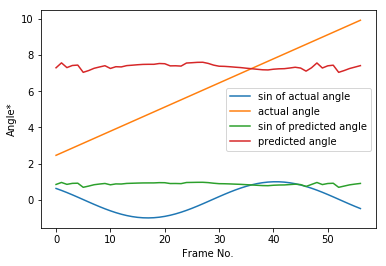

In [53]:
plt.plot(np.sin(y_true), label='sin of actual angle')
plt.plot(y_true, label = 'actual angle')
plt.plot(np.sin(y_pred), label='sin of predicted angle')
plt.plot(y_pred, label='predicted angle')


# plt.plot(var1, label='predicted var 1')
# plt.plot(var2, label='predicted var 2')
# plt.plot(np.sin(var1))
# plt.plot(np.sin(var2))
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.show()

In [36]:
# TESTING
test_vars = X_test[0]
angles = y_test[0]
var1 = test_vars[:, 0]
var2 = test_vars[:, 1]
print(test_vars.shape)
print(angles.shape)
print(var1.shape)
print(var2.shape)

torch.Size([57, 2])
torch.Size([57])
torch.Size([57])
torch.Size([57])


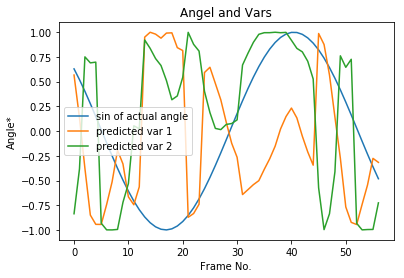

In [37]:
plt.plot(np.sin(angles), label='sin of actual angle')
plt.plot(var1, label='predicted var 1')
plt.plot(var2, label='predicted var 2')
# plt.plot(np.sin(var1))
# plt.plot(np.sin(var2))
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.title("Angel and Vars")
plt.show()

(57,)
(57,)


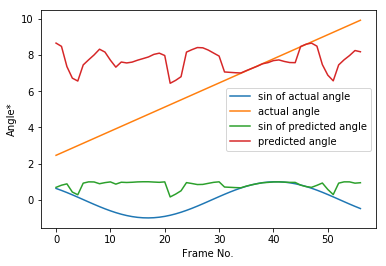

In [ ]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2, 32),
      nn.Tanh(),
      nn.Linear(32, 1),
    )
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    return self.layers(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.layers(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return optimizer

In [ ]:
from torchvision.datasets import CIFAR10
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
print(type(dataset))
#   pl.seed_everything(42)
#   mlp = MLP()
#   trainer = pl.Trainer(auto_scale_batch_size='power', gpus=0, deterministic=True, max_epochs=5)
#   trainer.fit(mlp, DataLoader(dataset))

In [15]:
# we only have predictions / variables for 1/10 of the training datasets
print(6270/57)

110.0


In [16]:
for i, id in enumerate(ids):
    print(i, id)

0 524_0.png
1 524_1.png
2 524_2.png
3 524_3.png
4 524_4.png
5 524_5.png
6 524_6.png
7 524_7.png
8 524_8.png
9 524_9.png
10 524_10.png
11 524_11.png
12 524_12.png
13 524_13.png
14 524_14.png
15 524_15.png
16 524_16.png
17 524_17.png
18 524_18.png
19 524_19.png
20 524_20.png
21 524_21.png
22 524_22.png
23 524_23.png
24 524_24.png
25 524_25.png
26 524_26.png
27 524_27.png
28 524_28.png
29 524_29.png
30 524_30.png
31 524_31.png
32 524_32.png
33 524_33.png
34 524_34.png
35 524_35.png
36 524_36.png
37 524_37.png
38 524_38.png
39 524_39.png
40 524_40.png
41 524_41.png
42 524_42.png
43 524_43.png
44 524_44.png
45 524_45.png
46 524_46.png
47 524_47.png
48 524_48.png
49 524_49.png
50 524_50.png
51 524_51.png
52 524_52.png
53 524_53.png
54 524_54.png
55 524_55.png
56 524_56.png
57 1032_0.png
58 1032_1.png
59 1032_2.png
60 1032_3.png
61 1032_4.png
62 1032_5.png
63 1032_6.png
64 1032_7.png
65 1032_8.png
66 1032_9.png
67 1032_10.png
68 1032_11.png
69 1032_12.png
70 1032_13.png
71 1032_14.png
72 1032

1859 12_35.png
1860 12_36.png
1861 12_37.png
1862 12_38.png
1863 12_39.png
1864 12_40.png
1865 12_41.png
1866 12_42.png
1867 12_43.png
1868 12_44.png
1869 12_45.png
1870 12_46.png
1871 12_47.png
1872 12_48.png
1873 12_49.png
1874 12_50.png
1875 12_51.png
1876 12_52.png
1877 12_53.png
1878 12_54.png
1879 12_55.png
1880 12_56.png
1881 1005_0.png
1882 1005_1.png
1883 1005_2.png
1884 1005_3.png
1885 1005_4.png
1886 1005_5.png
1887 1005_6.png
1888 1005_7.png
1889 1005_8.png
1890 1005_9.png
1891 1005_10.png
1892 1005_11.png
1893 1005_12.png
1894 1005_13.png
1895 1005_14.png
1896 1005_15.png
1897 1005_16.png
1898 1005_17.png
1899 1005_18.png
1900 1005_19.png
1901 1005_20.png
1902 1005_21.png
1903 1005_22.png
1904 1005_23.png
1905 1005_24.png
1906 1005_25.png
1907 1005_26.png
1908 1005_27.png
1909 1005_28.png
1910 1005_29.png
1911 1005_30.png
1912 1005_31.png
1913 1005_32.png
1914 1005_33.png
1915 1005_34.png
1916 1005_35.png
1917 1005_36.png
1918 1005_37.png
1919 1005_38.png
1920 1005_39.png


3803 681_41.png
3804 681_42.png
3805 681_43.png
3806 681_44.png
3807 681_45.png
3808 681_46.png
3809 681_47.png
3810 681_48.png
3811 681_49.png
3812 681_50.png
3813 681_51.png
3814 681_52.png
3815 681_53.png
3816 681_54.png
3817 681_55.png
3818 681_56.png
3819 247_0.png
3820 247_1.png
3821 247_2.png
3822 247_3.png
3823 247_4.png
3824 247_5.png
3825 247_6.png
3826 247_7.png
3827 247_8.png
3828 247_9.png
3829 247_10.png
3830 247_11.png
3831 247_12.png
3832 247_13.png
3833 247_14.png
3834 247_15.png
3835 247_16.png
3836 247_17.png
3837 247_18.png
3838 247_19.png
3839 247_20.png
3840 247_21.png
3841 247_22.png
3842 247_23.png
3843 247_24.png
3844 247_25.png
3845 247_26.png
3846 247_27.png
3847 247_28.png
3848 247_29.png
3849 247_30.png
3850 247_31.png
3851 247_32.png
3852 247_33.png
3853 247_34.png
3854 247_35.png
3855 247_36.png
3856 247_37.png
3857 247_38.png
3858 247_39.png
3859 247_40.png
3860 247_41.png
3861 247_42.png
3862 247_43.png
3863 247_44.png
3864 247_45.png
3865 247_46.png
38

5306 545_5.png
5307 545_6.png
5308 545_7.png
5309 545_8.png
5310 545_9.png
5311 545_10.png
5312 545_11.png
5313 545_12.png
5314 545_13.png
5315 545_14.png
5316 545_15.png
5317 545_16.png
5318 545_17.png
5319 545_18.png
5320 545_19.png
5321 545_20.png
5322 545_21.png
5323 545_22.png
5324 545_23.png
5325 545_24.png
5326 545_25.png
5327 545_26.png
5328 545_27.png
5329 545_28.png
5330 545_29.png
5331 545_30.png
5332 545_31.png
5333 545_32.png
5334 545_33.png
5335 545_34.png
5336 545_35.png
5337 545_36.png
5338 545_37.png
5339 545_38.png
5340 545_39.png
5341 545_40.png
5342 545_41.png
5343 545_42.png
5344 545_43.png
5345 545_44.png
5346 545_45.png
5347 545_46.png
5348 545_47.png
5349 545_48.png
5350 545_49.png
5351 545_50.png
5352 545_51.png
5353 545_52.png
5354 545_53.png
5355 545_54.png
5356 545_55.png
5357 545_56.png
5358 912_0.png
5359 912_1.png
5360 912_2.png
5361 912_3.png
5362 912_4.png
5363 912_5.png
5364 912_6.png
5365 912_7.png
5366 912_8.png
5367 912_9.png
5368 912_10.png
5369 91

In [8]:
df = np.load('./scripts/logs_circular_motion_refine-64_1/prediction_long_term/model_rollout/stability.npy')

In [9]:
print(df.shape)

(110, 29)


In [10]:
print(df)

[[0.42513606 0.12511013 0.0691979  ... 0.14652    0.0741086  0.05749899]
 [0.1488189  0.05255614 0.15649796 ... 0.05777638 0.15448833 0.04506393]
 [0.29985631 0.48760211 0.06594243 ... 0.04212693 0.14640474 0.07417089]
 ...
 [0.78958726 0.25922719 0.06898575 ... 0.14404491 0.07414602 0.05723037]
 [0.00244545 0.06084003 0.15224837 ... 0.15528372 0.07005972 0.05682437]
 [0.42513606 0.12511013 0.0691979  ... 0.14650923 0.0741182  0.05752001]]


In [16]:
min_loss = 1
min_row = 0
for row in range(df.shape[0]):
    print((row, df[row].mean()))
    if df[row][1] < min_loss:
        min_loss = df[row][1]
        min_row = row
print("MIN LOSS:", min_loss)

(0, 0.10505335392623112)
(1, 0.09304515381568465)
(2, 0.1132471827139821)
(3, 0.14390959120194974)
(4, 0.13637843291307317)
(5, 0.20561725055349284)
(6, 0.18488461795114464)
(7, 0.19127198488547884)
(8, 0.1554230622433383)
(9, 0.18371454163871961)
(10, 0.18580425090301012)
(11, 0.09149181823535212)
(12, 0.13556192866687117)
(13, 0.09441721237039771)
(14, 0.1731555826383932)
(15, 0.1000971877626304)
(16, 0.13673823532359353)
(17, 0.15543689899917307)
(18, 0.10918756391339261)
(19, 0.13151740925065403)
(20, 0.25501897523243877)
(21, 0.10748059147615628)
(22, 0.33525788472515755)
(23, 0.16083988182021883)
(24, 0.209204011243479)
(25, 0.17377800982573938)
(26, 0.19308869463616404)
(27, 0.14709117005033226)
(28, 0.1598863582174968)
(29, 0.19082108666670733)
(30, 0.09164333390071988)
(31, 0.13670430473726372)
(32, 0.09222803727306168)
(33, 0.15505133777985286)
(34, 0.09346123502172272)
(35, 0.10676789001144212)
(36, 0.12039040799798637)
(37, 0.2019957271886283)
(38, 0.2025947998566874)
(39, 

In [17]:
df2 = np.load('./scripts/logs_circular_motion_refine-64_1/prediction_long_term/model_rollout/stability.npy')
print(df2)

[[6.62070420e-03 8.07788316e-03 6.82267360e-03 ... 4.10123542e-03
  7.90984277e-03 1.31637296e-02]
 [2.43708715e-02 9.61202569e-03 6.23096433e-03 ... 3.87154178e-05
  3.66344932e-03 2.37392783e-02]
 [5.76618419e-04 3.10558230e-01 6.49203639e-03 ... 6.34848839e-03
  5.98904584e-03 4.40476742e-03]
 ...
 [2.09539030e-02 3.18954291e-04 3.26922489e-03 ... 1.31643396e-02
  1.73229969e-03 1.71233190e-03]
 [1.50859989e-02 2.40099765e-02 1.37103759e-02 ... 5.48589509e-03
  5.31311287e-03 3.55629460e-03]
 [2.91154999e-03 1.11628510e-02 1.35039296e-02 ... 9.02833417e-03
  5.46923792e-03 5.30208042e-03]]


In [18]:
for row in range(df2.shape[0]):
    print((row, df2[row].mean()))

(0, 0.06849647583570412)
(1, 0.026353803897203258)
(2, 0.02989199457505461)
(3, 0.0314520387320703)
(4, 0.0671243054655798)
(5, 0.027034160765369648)
(6, 0.044627829473248656)
(7, 0.0601645556930164)
(8, 0.034953424818954304)
(9, 0.03425379689737195)
(10, 0.03476493299767126)
(11, 0.06015650049906479)
(12, 0.0314538732686899)
(13, 0.07099552394983816)
(14, 0.0369051683787959)
(15, 0.03874724636889055)
(16, 0.040187821220727)
(17, 0.02331854179320889)
(18, 0.03499048736105986)
(19, 0.09587133217879956)
(20, 0.03969853247038153)
(21, 0.03693359646623039)
(22, 0.07841230282190673)
(23, 0.06799566594217422)
(24, 0.034690360794323576)
(25, 0.026201799452949138)
(26, 0.025683638684783766)
(27, 0.03576341167429526)
(28, 0.041002622259525355)
(29, 0.030749218468152886)
(30, 0.07840881128153153)
(31, 0.03693285600456875)
(32, 0.04143507220635064)
(33, 0.03483885072700073)
(34, 0.036906702303957865)
(35, 0.046459633963893104)
(36, 0.08988033314669557)
(37, 0.059013721020352836)
(38, 0.0625127132